In [1]:
import sys
import os
import shutil
import datetime
import re
import pandas as pd
from collections import Counter
sys.path.append(os.path.abspath("/home/jose/Dropbox/Doktorarbeit/"))
from reading_robot import load_data, tei2text, text2features, classify, process_labels, describe_data,feature_analysis, cull_data, st_tests, metadata2numbers, cluster, call_stylo, prepare_subcorpus, genre_as_graph
import scipy.stats as stats
import seaborn as sns
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
%matplotlib inline
from shutil import copyfile
import numpy as np
import networkx as nx
import pygraphviz

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
#make_tree("literary-fiction?", recoded_recat_metadata_df, quantied_metadata_df, outdir)

# Getting Data

In [3]:
ne_dir = "/home/jose/Dropbox/Doktorarbeit/novelasespanolas/"

In [4]:
wdir = "/home/jose/Dropbox/Doktorarbeit/ne_data/chap11/"

## Getting Files

In [5]:
copyfile(ne_dir + "exported/tags_ling_pos_diff_mw_ord_ent_70000_T.parquet", wdir +"tags_ling_pos_diff_mw_ord_ent_70000_T.parquet")
copyfile(ne_dir+"metadata_beta-opt-obl-structure.csv", wdir + "metadata_beta-opt-obl-structure.csv")
copyfile(ne_dir+"metadata_recategorized.csv", wdir + "metadata_recategorized.csv")
copyfile("/home/jose/Dropbox/Doktorarbeit/ne_data/chap5_1/labels_agreement.csv", wdir + "labels_agreement.csv")
copyfile(ne_dir+"rel_quantified_labels.csv", wdir + "rel_quantified_labels.csv")

copyfile("/home/jose/Dropbox/Doktorarbeit/ne_data/chap7_1/combined_results_metadata.csv", wdir + "combined_results_metadata.csv")


'/home/jose/Dropbox/Doktorarbeit/ne_data/chap11/combined_results_metadata.csv'

## Getting Metadata

In [6]:
metadata_df = pd.read_csv(wdir+"metadata_beta-opt-obl-structure.csv",index_col=0,sep=",").fillna(0)
metadata_df.shape

(358, 177)

In [7]:
metadata_df.head()

idno author.name         title  year supergenre   genre  \
ne0001  ne0001      Baroja     Mayorazgo  1903  narrative  novela   
ne0002  ne0002      Galdos  Misericordia  1889  narrative  novela   
ne0003  ne0003      Galdos       Nazarin  1895  narrative  novela   
ne0004  ne0004      Galdos         Halma  1895  narrative  novela   
ne0005  ne0005      Galdos      Tristana  1892  narrative  novela   

       subgenre.cligs.important author.country  author.viaf author.bne  ...    \
ne0001                  realist          Spain   36912891.0   XX842743  ...     
ne0002                  realist          Spain   71395987.0  XX1014802  ...     
ne0003                  realist          Spain   71395987.0  XX1014802  ...     
ne0004                  realist          Spain   71395987.0  XX1014802  ...     
ne0005            bildungsroman          Spain   71395987.0  XX1014802  ...     

       am.wnlex.noun.Topss am.wnlex.noun.relations am.wnlex.noun.attributes  \
ne0001                 121                      13                      483   
ne0002                 239                      39                      821   
ne0003                 253                      17                      725   
ne0004                 288                      24                     1061   
ne0005                 191                      17                      705   

       am.wnlex.verb.emotions am.wnlex.noun.locations am.wnlex.noun.events  \
ne0001                    200                     312                  177   
ne0002                    314                     336                  355   
ne0003                    396                     301                  327   
ne0004                    424                     282                  248   
ne0005                    456                     174                  229   

       am.wnlex.verb.contacts am.wnlex.xxxs am.wnlex.verb.changes decade  
ne0001                    518         41371                   655   1900  
ne0002                    684         70169                   764   1880  
ne0003                    498         54401                   572   1890  
ne0004                    450         60648                   553   1890  
ne0005                    415         43359                   446   1890  

[5 rows x 177 columns]

In [8]:
independent_sources_genre = ['subgenre.cligs', 'subgenre.lithist.MdLE', 'subgenre.lithist.HdLE', 'subgenre.edit.epublibre', 'subgenre.edit.amazon','subgenre.subtitle.bne','subgenre.cluster']

In [9]:
metadata_df["number.sources"] = 0
for index, row in metadata_df.iterrows():
    i = 0
    for independent_source_genre in independent_sources_genre:

        if row[independent_source_genre] != 0:
            i += 1
    metadata_df.loc[index,"number.sources"] = i
    

In [10]:
metadata_df[independent_sources_genre+["number.sources"]]

subgenre.cligs  \
ne0001              naturalist,sentimental,social,realist   
ne0002                          naturalist,social,realist   
ne0003                naturalist,social,spiritual,realist   
ne0004               sentimental,social,spiritual,realist   
ne0005  naturalist,realist,sentimental,social,spiritua...   
ne0006  naturalist,realist,sentimental,social,spiritua...   
ne0007                   naturalist,realist,social,erotic   
ne0008                              realist,social,erotic   
ne0009  naturalist,realist,sentimental,social,bildungs...   
ne0010                               social,philosophical   
ne0011    memoir,realist,sentimental,social,philosophical   
ne0013               memoir,modernist,realist,sentimental   
ne0014     adventure,memoir,modernist,realist,sentimental   
ne0015               memoir,modernist,realist,sentimental   
ne0016    historical,memoir,modernist,realist,sentimental   
ne0017  fantastic,modernist,naturalist,sentimental,soc...   
ne0018                          crime-fiction,sentimental   
ne0019                          naturalist,social,realist   
ne0020      adventure,realist,social,war-novel,historical   
ne0021      adventure,realist,social,war-novel,historical   
ne0022      adventure,realist,social,war-novel,historical   
ne0023                                      philosophical   
ne0024  naturalist,philosophical,realist,social,bildun...   
ne0025                                      erotic,comedy   
ne0026                  realist,sentimental,social,erotic   
ne0027                          naturalist,social,realist   
ne0028              naturalist,sentimental,social,realist   
ne0029       memoir,naturalist,realist,sentimental,social   
ne0030        political-fiction,realist,social,historical   
ne0031                          naturalist,social,realist   
...                                                   ...   
ne0360          science-fiction,sentimental,philosophical   
ne0361                modernist,symbolic,autobiographical   
ne0362                                   comedy,adventure   
ne0363                    costumbrista,sentimental,social   
ne0364                 historical,philosophical,war-novel   
ne0365  philosophical,political-fiction,symbolic,fanta...   
ne0370                 philosophical,war-novel,historical   
ne0373                               crime-fiction,erotic   
ne0378                                      comedy,social   
ne0379  historical,philosophical,psicological,realist,...   
ne0380                          crime-fiction,vanguardist   
ne0381                   comedy,sentimental,philosophical   
ne0382                                     realist,social   
ne0384                          naturalist,social,realist   
ne0385                                realist,sentimental   
ne0387                   bildungsroman,realist,historical   
ne0388                       philosophical,realist,social   
ne0390                                     realist,social   
ne0391                   bildungsroman,social,sentimental   
ne0392                   bildungsroman,social,sentimental   
ne0393  autobiographical,philosophical,realist,bildung...   
ne0394       autobiographical,philosophical,bildungsroman   
ne0395                                 social,sentimental   
ne0396                                     realist,social   
ne0397                              modernist,sentimental   
ne0398                         sentimental,social,realist   
ne0399                  antireligous,philosophical,social   
ne0401                          vanguardist,philosophical   
ne0403                                 social,sentimental   
ne0404                              comedy,realist,social   

                                    subgenre.lithist.MdLE  \
ne0001                                                  0   
ne0002                                    novela de tesis   
ne0003                              novela espiritualista   
ne0004          

In [11]:
semantic_subgenres_lt = ["autobiografía","aventura","biografía","costumbrista","diálogo","educación","episodio nacional","erótica","espiritual","fantástico","filosófica","greguería","guerra","histórica","humor","memorias","modernista","naturalista","nivola","poética","psicológica","realista","social","bucólica","mono-diálogo","ficción-literaria"]

In [12]:
rel_quantified_subgenres_df = pd.read_csv(wdir+"rel_quantified_labels.csv",sep="\t", index_col=0)

In [13]:
rel_quantified_subgenres_df.head(20)

autobiografía  aventura  biografía  costumbrista  diálogo  educación  \
ne0001            0.0  0.333333        0.0           0.0      0.0       0.00   
ne0002            0.0  0.000000        0.0           0.0      0.0       0.00   
ne0003            0.0  0.000000        0.0           0.0      0.0       0.00   
ne0004            0.0  0.000000        0.0           0.0      0.0       0.00   
ne0005            0.0  0.000000        0.0           0.0      0.0       0.25   
ne0006            0.0  0.000000        0.0           0.0      0.0       0.25   
ne0007            0.0  0.000000        0.0           0.0      0.0       0.00   
ne0008            0.0  0.000000        0.0           0.0      0.0       0.00   
ne0009            0.0  0.000000        0.0           0.0      0.0       0.20   
ne0010            0.0  0.000000        0.0           0.0      0.0       0.00   
ne0011            0.0  0.000000        0.0           0.0      0.0       0.40   
ne0013            0.0  0.000000        0.0           0.0      0.0       0.00   
ne0014            0.0  0.200000        0.0           0.0      0.0       0.00   
ne0015            0.0  0.200000        0.0           0.0      0.0       0.00   
ne0016            0.0  0.000000        0.0           0.0      0.0       0.00   
ne0017            0.0  0.000000        0.0           0.0      0.0       0.00   
ne0018            0.0  0.000000        0.0           0.0      0.0       0.00   
ne0019            0.0  0.000000        0.0           0.0      0.0       0.00   
ne0020            0.0  0.500000        0.0           0.0      0.0       0.00   
ne0021            0.0  0.500000        0.0           0.0      0.0       0.00   

        episodio nacional  erótica  espiritual  fantástico        ...          \
ne0001                0.0      0.0         0.0        0.00        ...           
ne0002                0.0      0.0         0.0        0.25        ...           
ne0003                0.0      0.0         0.5        0.00        ...           
ne0004                0.0      0.0         0.5        0.00        ...           
ne0005                0.0      0.0         0.5        0.00        ...           
ne0006                0.0      0.0         0.5        0.00        ...           
ne0007                0.0      0.2         0.0        0.00        ...           
ne0008                0.0      0.5         0.0        0.00        ...           
ne0009                0.0      0.0         0.0        0.00        ...           
ne0010                0.0      0.0         0.0        0.00        ...           
ne0011                0.0      0.0         0.0        0.00        ...           
ne0013                0.0      0.0         0.0        0.00        ...           
ne0014                0.0      0.0         0.0        0.00        ...           
ne0015                0.0      0.0         0.0        0.00        ...           
ne0016                0.0      0.0         0.0        0.00        ...           
ne0017                0.0      0.0         0.2        0.20        ...           
ne0018                0.0      0.0         0.0        0.00        ...           
ne0019                0.0      0.0         0.0        0.00        ...           
ne0020                0.0      0.0         0.0        0.00        ...           
ne0021                0.0      0.0         0.0        0.00        ...           

        modernista  naturalista  nivola  poética  psicológica  realista  \
ne0001         0.0     0.333333     0.0      0.0          0.0  0.333333   
ne0002         0.0     0.250000     0.0      0.0          0.0  0.500000   
ne0003         0.0     0.250000     0.0      0.0          0.0  0.250000   
ne0004         0.0     0.000000     0.0      0.0          0.0  0.500000   
ne0005         0.0     0.250000     0.0      0.0          0.0  0.500000   
ne0006         0.0     0.250000     0.0      0.0          0.0  0.500000   
ne0007         0.0     0.600000     0.0      0.0          0.0  0.200000   
ne0008         0.0     0.

In [14]:
metadata_df.loc[metadata_df["author.name"]=="Valle"]

idno author.name               title  year   supergenre   genre  \
ne0013  ne0013       Valle         SonataOtono  1902    narrative  novela   
ne0014  ne0014       Valle         SonataEstio  1903    narrative  novela   
ne0015  ne0015       Valle     SonataPrimavera  1904    narrative  novela   
ne0016  ne0016       Valle      SonataInvierno  1905    narrative  novela   
ne0017  ne0017       Valle      FlordeSantidad  1904    narrative  novela   
ne0020  ne0020       Valle       CruzadosCausa  1908    narrative  novela   
ne0021  ne0021       Valle   ResplandorHoguera  1909    narrative  novela   
ne0022  ne0022       Valle    GerifaltesAntano  1909    narrative  novela   
ne0023  ne0023       Valle  LamparaMaravillosa  1916  non-fiction       ?   
ne0030  ne0030       Valle      TiranoBanderas  1926    narrative  novela   
ne0033  ne0033       Valle               Corte  1927    narrative  novela   
ne0035  ne0035       Valle                Viva  1928    narrative  novela   
ne0036  ne0036       Valle                Baza  1932    narrative  novela   
ne0037  ne0037       Valle          MediaNoche  1917    narrative       ?   

       subgenre.cligs.important author.country  author.viaf author.bne  \
ne0013                   memoir          Spain   68936773.0  XX1055436   
ne0014                   memoir          Spain   68936773.0  XX1055436   
ne0015                   memoir          Spain   68936773.0  XX1055436   
ne0016                   memoir          Spain   68936773.0  XX1055436   
ne0017                   social          Spain   68936773.0  XX1055436   
ne0020               historical          Spain   68936773.0  XX1055436   
ne0021               historical          Spain   68936773.0  XX1055436   
ne0022               historical          Spain   68936773.0  XX1055436   
ne0023            philosophical          Spain   68936773.0  XX1055436   
ne0030               historical          Spain   68936773.0  XX1055436   
ne0033               historical          Spain   68936773.0  XX1055436   
ne0035               historical          Spain   68936773.0  XX1055436   
ne0036               historical          Spain   68936773.0  XX1055436   
ne0037               historical          Spain   68936773.0  XX1055436   

            ...       am.wnlex.noun.relations am.wnlex.noun.attributes  \
ne0013      ...                             1                      222   
ne0014      ...                             4                      261   
ne0015      ...                             0                      253   
ne0016      ...                             3                      296   
ne0017      ...                             0                      180   
ne0020      ...                             2                      204   
ne0021      ...                             1                      257   
ne0022      ...                             2                      206   
ne0023      ...                             1                       38   
ne0030      ...                            19                      422   
ne0033      ...                            13                      657   
ne0035      ...                             9                      774   
ne0036      ...                             9                      505   
ne0037      ...                             1                      119   

       am.wnlex.verb.emotions am.wnlex.noun.locations am.wnlex.noun.events  \
ne0013                    137                      86                   76   
ne0014                    121                     103                   85   
ne0015                    116                     103                   86   
ne0016                    162                      96                  108   
ne0017                     56                     145                   83   
ne0020                     79                      94                   75   
ne0021                     53                     134                   80   
ne0022  

In [15]:
rel_quantified_subgenres_df.loc["ne0037"]

autobiografía        0.00
aventura             0.00
biografía            0.00
costumbrista         0.00
diálogo              0.00
educación            0.00
episodio nacional    0.00
erótica              0.00
espiritual           0.00
fantástico           0.00
filosófica           0.00
greguería            0.00
guerra               0.25
histórica            0.25
humor                0.00
memorias             0.00
modernista           0.00
naturalista          0.00
nivola               0.00
poética              0.00
psicológica          0.00
realista             0.25
social               0.25
bucólica             0.25
mono-diálogo         0.00
ficción-literaria    0.25
Name: ne0037, dtype: float64

In [16]:
bool_quantified_subgenre_df = (rel_quantified_subgenres_df > 0).astype(int)
bool_quantified_subgenre_df.head(15)

autobiografía  aventura  biografía  costumbrista  diálogo  educación  \
ne0001              0         1          0             0        0          0   
ne0002              0         0          0             0        0          0   
ne0003              0         0          0             0        0          0   
ne0004              0         0          0             0        0          0   
ne0005              0         0          0             0        0          1   
ne0006              0         0          0             0        0          1   
ne0007              0         0          0             0        0          0   
ne0008              0         0          0             0        0          0   
ne0009              0         0          0             0        0          1   
ne0010              0         0          0             0        0          0   
ne0011              0         0          0             0        0          1   
ne0013              0         0          0             0        0          0   
ne0014              0         1          0             0        0          0   
ne0015              0         1          0             0        0          0   
ne0016              0         0          0             0        0          0   

        episodio nacional  erótica  espiritual  fantástico        ...          \
ne0001                  0        0           0           0        ...           
ne0002                  0        0           0           1        ...           
ne0003                  0        0           1           0        ...           
ne0004                  0        0           1           0        ...           
ne0005                  0        0           1           0        ...           
ne0006                  0        0           1           0        ...           
ne0007                  0        1           0           0        ...           
ne0008                  0        1           0           0        ...           
ne0009                  0        0           0           0        ...           
ne0010                  0        0           0           0        ...           
ne0011                  0        0           0           0        ...           
ne0013                  0        0           0           0        ...           
ne0014                  0        0           0           0        ...           
ne0015                  0        0           0           0        ...           
ne0016                  0        0           0           0        ...           

        modernista  naturalista  nivola  poética  psicológica  realista  \
ne0001           0            1       0        0            0         1   
ne0002           0            1       0        0            0         1   
ne0003           0            1       0        0            0         1   
ne0004           0            0       0        0            0         1   
ne0005           0            1       0        0            0         1   
ne0006           0            1       0        0            0         1   
ne0007           0            1       0        0            0         1   
ne0008           0            0       0        0            0         1   
ne0009           0            1       0        0            0         1   
ne0010           0            0       0        0            0         0   
ne0011           0            1       0        0            0         1   
ne0013           1            0       0        0            0         1   
ne0014           1            0       0        0            0         1   
ne0015           1            0       0        0            0         1   
ne0016           1            0       0        0            0         1   

        social  bucólica  mono-diálogo  ficción-literaria  
ne0001       1         0             0                  1  
ne0002       1         0             0                  1  
ne0003       1         0             0           

In [17]:
new_metadata_df = pd.concat([metadata_df, rel_quantified_subgenres_df], axis=1)
new_metadata_df = new_metadata_df.loc[(new_metadata_df["genre.analyzed"]=="novela")]
new_metadata_df.shape

(352, 204)

In [18]:
new_metadata_df["mean.prop.subgenres"] = rel_quantified_subgenres_df.mean(axis=1)

In [19]:
new_metadata_df.head()

idno author.name         title  year supergenre   genre  \
ne0001  ne0001      Baroja     Mayorazgo  1903  narrative  novela   
ne0002  ne0002      Galdos  Misericordia  1889  narrative  novela   
ne0003  ne0003      Galdos       Nazarin  1895  narrative  novela   
ne0004  ne0004      Galdos         Halma  1895  narrative  novela   
ne0005  ne0005      Galdos      Tristana  1892  narrative  novela   

       subgenre.cligs.important author.country  author.viaf author.bne  \
ne0001                  realist          Spain   36912891.0   XX842743   
ne0002                  realist          Spain   71395987.0  XX1014802   
ne0003                  realist          Spain   71395987.0  XX1014802   
ne0004                  realist          Spain   71395987.0  XX1014802   
ne0005            bildungsroman          Spain   71395987.0  XX1014802   

               ...         naturalista nivola poética psicológica  realista  \
ne0001         ...            0.333333    0.0     0.0         0.0  0.333333   
ne0002         ...            0.250000    0.0     0.0         0.0  0.500000   
ne0003         ...            0.250000    0.0     0.0         0.0  0.250000   
ne0004         ...            0.000000    0.0     0.0         0.0  0.500000   
ne0005         ...            0.250000    0.0     0.0         0.0  0.500000   

          social bucólica mono-diálogo ficción-literaria mean.prop.subgenres  
ne0001  0.333333      0.0          0.0          0.333333            0.064103  
ne0002  0.250000      0.0          0.0          0.250000            0.067308  
ne0003  0.250000      0.0          0.0          0.250000            0.057692  
ne0004  0.250000      0.0          0.0          0.250000            0.057692  
ne0005  0.250000      0.0          0.0          0.250000            0.076923  

[5 rows x 205 columns]

In [20]:
new_metadata_canon_df = new_metadata_df.loc[new_metadata_df["CoNSSA.canon"]==True]

In [21]:
new_metadata_canon_df.head()

idno author.name         title  year supergenre   genre  \
ne0002  ne0002      Galdos  Misericordia  1889  narrative  novela   
ne0003  ne0003      Galdos       Nazarin  1895  narrative  novela   
ne0004  ne0004      Galdos         Halma  1895  narrative  novela   
ne0006  ne0006      Galdos         Angel  1891  narrative  novela   
ne0009  ne0009      Galdos   Desheredada  1881  narrative  novela   

       subgenre.cligs.important author.country  author.viaf author.bne  \
ne0002                  realist          Spain   71395987.0  XX1014802   
ne0003                  realist          Spain   71395987.0  XX1014802   
ne0004                  realist          Spain   71395987.0  XX1014802   
ne0006            bildungsroman          Spain   71395987.0  XX1014802   
ne0009            bildungsroman          Spain   71395987.0  XX1014802   

               ...         naturalista nivola poética psicológica realista  \
ne0002         ...                0.25    0.0     0.0         0.0     0.50   
ne0003         ...                0.25    0.0     0.0         0.0     0.25   
ne0004         ...                0.00    0.0     0.0         0.0     0.50   
ne0006         ...                0.25    0.0     0.0         0.0     0.50   
ne0009         ...                0.40    0.0     0.0         0.0     0.40   

       social bucólica mono-diálogo ficción-literaria mean.prop.subgenres  
ne0002   0.25      0.0          0.0              0.25            0.067308  
ne0003   0.25      0.0          0.0              0.25            0.057692  
ne0004   0.25      0.0          0.0              0.25            0.057692  
ne0006   0.25      0.0          0.0              0.25            0.076923  
ne0009   0.20      0.0          0.0              0.20            0.061538  

[5 rows x 205 columns]

In [22]:
bool_new_metadata_df = pd.concat([metadata_df, bool_quantified_subgenre_df ], axis=1)
bool_new_metadata_df = bool_new_metadata_df.loc[(bool_new_metadata_df["genre.analyzed"]=="novela")]
bool_new_metadata_df.shape

(352, 204)

In [23]:
bool_new_metadata_df.head()

idno author.name         title  year supergenre   genre  \
ne0001  ne0001      Baroja     Mayorazgo  1903  narrative  novela   
ne0002  ne0002      Galdos  Misericordia  1889  narrative  novela   
ne0003  ne0003      Galdos       Nazarin  1895  narrative  novela   
ne0004  ne0004      Galdos         Halma  1895  narrative  novela   
ne0005  ne0005      Galdos      Tristana  1892  narrative  novela   

       subgenre.cligs.important author.country  author.viaf author.bne  \
ne0001                  realist          Spain   36912891.0   XX842743   
ne0002                  realist          Spain   71395987.0  XX1014802   
ne0003                  realist          Spain   71395987.0  XX1014802   
ne0004                  realist          Spain   71395987.0  XX1014802   
ne0005            bildungsroman          Spain   71395987.0  XX1014802   

              ...        modernista naturalista nivola poética psicológica  \
ne0001        ...                 0           1      0       0           0   
ne0002        ...                 0           1      0       0           0   
ne0003        ...                 0           1      0       0           0   
ne0004        ...                 0           0      0       0           0   
ne0005        ...                 0           1      0       0           0   

       realista social bucólica mono-diálogo ficción-literaria  
ne0001        1      1        0            0                 1  
ne0002        1      1        0            0                 1  
ne0003        1      1        0            0                 1  
ne0004        1      1        0            0                 1  
ne0005        1      1        0            0                 1  

[5 rows x 204 columns]

In [24]:
texts_without_genre_lt = bool_new_metadata_df[semantic_subgenres_lt].sum(axis=1).sort_values().loc[bool_new_metadata_df[semantic_subgenres_lt].sum(axis=1).sort_values()== 0].index.tolist()


In [25]:
texts_split = ["ne0322","ne0323","ne0324","ne0326"]


In [26]:
metadata_recategorized_df = pd.read_csv(wdir+"metadata_recategorized.csv",sep="\t", index_col=0)
metadata_recategorized_df.head()

idno author.name         title  year supergenre   genre  \
ne0001  ne0001      Baroja     Mayorazgo  1903  narrative  novela   
ne0002  ne0002      Galdos  Misericordia  1889  narrative  novela   
ne0003  ne0003      Galdos       Nazarin  1895  narrative  novela   
ne0004  ne0004      Galdos         Halma  1895  narrative  novela   
ne0005  ne0005      Galdos      Tristana  1892  narrative  novela   

       subgenre.cligs.important author.country  author.viaf author.bne  \
ne0001                  realist          Spain   36912891.0   XX842743   
ne0002                  realist          Spain   71395987.0  XX1014802   
ne0003                  realist          Spain   71395987.0  XX1014802   
ne0004                  realist          Spain   71395987.0  XX1014802   
ne0005            bildungsroman          Spain   71395987.0  XX1014802   

                ...           author.movement_ordinal  \
ne0001          ...                                 1   
ne0002          ...                                 0   
ne0003          ...                                 0   
ne0004          ...                                 0   
ne0005          ...                                 0   

       author.submovement_ordinal authorText.relation_ordinal  \
ne0001                          4                           0   
ne0002                          0                           0   
ne0003                          0                           0   
ne0004                          0                           0   
ne0005                          0                           0   

       litHist.brow_ordinal setting.type_ordinal time.period_ordinal  \
ne0001                  NaN                    1                   3   
ne0002                  NaN                    3                   3   
ne0003                  0.0                    -                   3   
ne0004                  NaN                    3                   3   
ne0005                  NaN                    3                   3   

       protagonist.age_ordinal protagonist.socLevel_ordinal end_ordinal  \
ne0001                       3                            2           4   
ne0002                       2                            0           0   
ne0003                       2                            0           4   
ne0004                       2                            2           4   
ne0005                       1                            0           3   

       representation_ordinal  
ne0001                      2  
ne0002                      2  
ne0003                      2  
ne0004                      2  
ne0005                      2  

[5 rows x 183 columns]

In [27]:
rel_new_metadata_df = new_metadata_df.copy()
linguistic_features_raw_lt = [ 'am.chars', 'am.divs', 'am.verses', 'am.sps', 'am.paragraphs', 'am.pds', 'am.numerals', 'am.puncts', 'am.blocks', 'am.chapters', 'am.shortStories', 'am.parts', 'am.sections', 'am.divisions', 'am.lg.poems', 'am.lg.stanzas', 'am.saids', 'am.narrative.ps', 'am.punctual.ss', 'len.abstract', 'am.fts', 'len.chapters.mean', 'len.chapters.std', 'len.chapters.median', 'len.chapters.iqr', 'am.conjunctions', 'am.determiners', 'am.nouns', 'am.verbs', 'am.adverbs', 'am.adjectives', 'am.adpositions', 'am.punctuations', 'am.pronouns', 'am.dates', 'am.numbers', 'am.interjections', 'am.ne.persons', 'am.ne.organizations', 'am.ne.locations', 'am.ne.others', 'am.ss', 'len.ss.mean', 'len.ss.std', 'len.ss.median', 'len.ss.iqr', 'am.ss.active.verbs.mean', 'am.ss.active.verbs.std', 'am.ss.active.verbs.median', 'am.ss.active.verbs.iqr', 'am.ws', 'am.ws.num.mean', 'am.ws.num.std', 'am.ws.num.median', 'am.ws.num.iqr', 'am.wnlex.noun.plants', 'am.wnlex.verb.communications', 'am.wnlex.noun.foods', 'am.wnlex.verb.possessions', 'am.wnlex.verb.cognitions', 'am.wnlex.noun.communications', 'am.wnlex.noun.states', 'am.wnlex.verb.statives', 'am.wnlex.noun.cognitions', 'am.wnlex.noun.times', 'am.wnlex.verb.bodys', 'am.wnlex.noun.persons', 'am.wnlex.adj.alls', 'am.wnlex.noun.quantitys', 'am.wnlex.noun.phenomenons', 'am.wnlex.verb.creations', 'am.wnlex.adj.perts', 'am.wnlex.adv.alls', 'am.wnlex.noun.processs', 'am.wnlex.noun.artifacts', 'am.wnlex.verb.perceptions', 'am.wnlex.noun.feelings', 'am.wnlex.verb.weathers', 'am.wnlex.noun.substances', 'am.wnlex.noun.shapes', 'am.wnlex.verb.competitions', 'am.wnlex.verb.motions', 'am.wnlex.noun.animals', 'am.wnlex.noun.acts', 'am.wnlex.noun.bodys', 'am.wnlex.noun.objects', 'am.wnlex.noun.motives', 'am.wnlex.verb.socials', 'am.wnlex.noun.groups', 'am.wnlex.verb.consumptions', 'am.wnlex.noun.possessions', 'am.wnlex.noun.Topss', 'am.wnlex.noun.relations', 'am.wnlex.noun.attributes', 'am.wnlex.verb.emotions', 'am.wnlex.noun.locations', 'am.wnlex.noun.events', 'am.wnlex.verb.contacts', 'am.wnlex.xxxs', 'am.wnlex.verb.changes']
for column in linguistic_features_raw_lt:
    rel_new_metadata_df[column] = rel_new_metadata_df[column] / rel_new_metadata_df["am.tokens"]


In [28]:
numerical_metadata_lt = ['time.span',
                    ]

In [29]:
rel_new_metadata_df.columns.tolist()

['idno',
 'author.name',
 'title',
 'year',
 'supergenre',
 'genre',
 'subgenre.cligs.important',
 'author.country',
 'author.viaf',
 'author.bne',
 'author.gender',
 'title.main',
 'title.viaf',
 'title.bne',
 'author.name.full',
 'subtitle',
 'availability',
 'subgenre.cligs',
 'genre.analyzed',
 'genre.analyzed.cert',
 'date.file',
 'digital.source',
 'digital.source.format',
 'genre.subtitle',
 'narrator',
 'protagonist.gender',
 'setting.type',
 'form',
 'publication',
 'digital.source.idno',
 'author.continent',
 'authorText.group',
 'authorText.subgroup',
 'protagonist.name',
 'protagonist.age',
 'protagonist.socLevel',
 'protagonist.profession',
 'representation',
 'setting.continent',
 'setting.country',
 'setting.settlement',
 'setting.territory',
 'text.movement',
 'time.period',
 'time.span',
 'authorText.relation',
 'end',
 'time.year',
 'keywords.cert',
 'author.movement',
 'author.submovement',
 'author.date.birth',
 'author.date.death',
 'litHist.literaryQuality',
 'lit

In [30]:
categorical_metadata_lt = [
                         'narrator', 'protagonist.gender',
                        #'protagonist.profession', 
                        'setting.continent', 'setting.country',
                        'setting.settlement.represented.exist',
    'setting.type', 'time.period',
                    'protagonist.age', 'protagonist.socLevel',
                    'end', 'representation','authorText.relation'
                        ]

In [31]:
numerical_metadata_features_df = metadata2numbers.replace_non_numerical_with_mode(metadata_recategorized_df[numerical_metadata_lt], numerical_metadata_lt).fillna(0)
print(numerical_metadata_features_df.shape)
numerical_metadata_features_df.head()


(358, 1)


time.span
ne0001      365.0
ne0002       90.0
ne0003       90.0
ne0004      365.0
ne0005     1800.0

In [32]:
minmax_numerical_metadata_features_df = text2features.calculate_minmax(numerical_metadata_features_df)

In [33]:
minmax_numerical_metadata_features_df.head()

time.span
ne0001   0.014286
ne0002   0.003523
ne0003   0.003523
ne0004   0.014286
ne0005   0.070450

In [34]:
categorical_metadata_features_df = pd.get_dummies(metadata_recategorized_df[categorical_metadata_lt])
categorical_metadata_features_df = categorical_metadata_features_df.loc[:, (categorical_metadata_features_df.sum() > 2)]
    
print(categorical_metadata_features_df.shape)
categorical_metadata_features_df.head()

(358, 52)


setting.settlement.represented.exist  narrator_autodiegetic  \
ne0001                                  True                      0   
ne0002                                  True                      0   
ne0003                                  True                      0   
ne0004                                  True                      0   
ne0005                                  True                      0   

        narrator_dialogue  narrator_epistolary  narrator_heterodiegetic  \
ne0001                  0                    0                        0   
ne0002                  0                    0                        1   
ne0003                  0                    0                        0   
ne0004                  0                    0                        0   
ne0005                  0                    0                        1   

        narrator_homodiegetic  narrator_mixed  protagonist.gender_female  \
ne0001                      1               0                          0   
ne0002                      0               0                          1   
ne0003                      1               0                          0   
ne0004                      1               0                          0   
ne0005                      0               0                          1   

        protagonist.gender_male  protagonist.gender_other  \
ne0001                        1                         0   
ne0002                        0                         0   
ne0003                        1                         0   
ne0004                        0                         0   
ne0005                        0                         0   

                  ...             end_partial negative  end_partial positive  \
ne0001            ...                                0                     0   
ne0002            ...                                0                     0   
ne0003            ...                                0                     0   
ne0004            ...                                0                     0   
ne0005            ...                                0                     1   

        end_positive  representation_neutral  representation_non-realistic  \
ne0001             1                       0                             0   
ne0002             0                       0                             0   
ne0003             1                       0                             0   
ne0004             1                       0                             0   
ne0005             0                       0                             0   

        representation_realistic  authorText.relation_high  \
ne0001                         1                         0   
ne0002                         1                         0   
ne0003                         1                         0   
ne0004                         1                         0   
ne0005                         1                         0   

        authorText.relation_low  authorText.relation_medium  \
ne0001                        0                           0   
ne0002                        0                           0   
ne0003                        0                           0   
ne0004                        0                           0   
ne0005                        0                           0   

        authorText.relation_none  
ne0001                         1  
ne0002                         1  
ne0003                         1  
ne0004                         1  
ne0005                         1  

[5 rows x 52 columns]

In [35]:
categorical_metadata_features_df.sum().sort_values()

narrator_epistolary                       3.0
time.period_middle_ages                   3.0
setting.continent_Asia                    3.0
protagonist.gender_other                  4.0
setting.continent_other                   4.0
setting.country_Italy                     5.0
time.period_antiquity                     5.0
narrator_mixed                            5.0
setting.continent_Africa                  6.0
setting.type_?                            6.0
end_?                                     7.0
setting.continent_America                 8.0
time.period_modern_times                  8.0
narrator_dialogue                         9.0
setting.type_boat                        11.0
setting.type_mixed                       12.0
representation_neutral                   13.0
setting.continent_mixed                  14.0
protagonist.socLevel_?                   14.0
protagonist.age_?                        14.0
setting.country_France                   15.0
end_partial positive              

In [36]:
metadata_features_df = pd.merge(categorical_metadata_features_df,minmax_numerical_metadata_features_df, right_index=True, left_index=True)

In [37]:
metadata_features_df = metadata_features_df.loc[new_metadata_df.index.tolist()]

In [38]:
metadata_features_df = metadata_features_df.reindex_axis(metadata_features_df.mean().sort_values(ascending=False).index, axis=1)

In [39]:
zscores_metadata_features_df = text2features.calculate_zscore(metadata_features_df).dropna(axis="columns")
zscores_metadata_features_df

time.period_contemporary setting.settlement.represented.exist  \
ne0001                  0.251523                             0.257832   
ne0002                  0.251523                             0.257832   
ne0003                  0.251523                             0.257832   
ne0004                  0.251523                             0.257832   
ne0005                  0.251523                             0.257832   
ne0006                  0.251523                             0.257832   
ne0007                  0.251523                             0.257832   
ne0008                  0.251523                             0.257832   
ne0009                  0.251523                             0.257832   
ne0010                  0.251523                             0.257832   
ne0011                  0.251523                             0.257832   
ne0013                  0.251523                             0.257832   
ne0014                  0.251523                             0.257832   
ne0015                  0.251523                             0.257832   
ne0016                  0.251523                             0.257832   
ne0017                 -3.964483                             0.257832   
ne0018                  0.251523                             0.257832   
ne0019                  0.251523                             0.257832   
ne0020                  0.251523                             0.257832   
ne0021                  0.251523                             0.257832   
ne0022                  0.251523                             0.257832   
ne0024                  0.251523                             0.257832   
ne0025                  0.251523                             0.257832   
ne0026                  0.251523                             0.257832   
ne0027                  0.251523                             0.257832   
ne0028                  0.251523                             0.257832   
ne0029                  0.251523                             0.257832   
ne0030                  0.251523                             0.257832   
ne0031                  0.251523                             0.257832   
ne0032                  0.251523                             0.257832   
...                          ...                                  ...   
ne0360                  0.251523                             0.257832   
ne0361                  0.251523                             0.257832   
ne0362                  0.251523                             0.257832   
ne0363                  0.251523                             0.257832   
ne0364                  0.251523                             0.257832   
ne0365                  0.251523                             -3.86748   
ne0370                  0.251523                             -3.86748   
ne0373                  0.251523                             0.257832   
ne0378                  0.251523                             -3.86748   
ne0379                  0.251523                             -3.86748   
ne0380                  0.251523                             -3.86748   
ne0381                  0.251523                             -3.86748   
ne0382                  0.251523                             0.257832   
ne0384                  0.251523                             0.257832   
ne0385                  0.251523                             0.257832   
ne0387                 -3.964483                             0.257832   
ne0388                  0.251523                             0.257832   
ne0390                  0.251523                             0.257832   
ne0391                  0.251523                             0.257832   
ne0392                  0.251523                             0.257832   
ne0393                  0.251523                             0.257832   
ne0394                  0.251523                             0.257832   
ne0395                  0.251523                             0.257

In [40]:
zscores_metadata_features_df["narrator_autodiegetic"]

ne0001   -0.401568
ne0002   -0.401568
ne0003   -0.401568
ne0004   -0.401568
ne0005   -0.401568
ne0006   -0.401568
ne0007   -0.401568
ne0008   -0.401568
ne0009   -0.401568
ne0010   -0.401568
ne0011    2.483165
ne0013    2.483165
ne0014    2.483165
ne0015    2.483165
ne0016    2.483165
ne0017   -0.401568
ne0018   -0.401568
ne0019   -0.401568
ne0020   -0.401568
ne0021   -0.401568
ne0022   -0.401568
ne0024   -0.401568
ne0025   -0.401568
ne0026   -0.401568
ne0027   -0.401568
ne0028   -0.401568
ne0029    2.483165
ne0030   -0.401568
ne0031   -0.401568
ne0032   -0.401568
            ...   
ne0360   -0.401568
ne0361   -0.401568
ne0362   -0.401568
ne0363   -0.401568
ne0364   -0.401568
ne0365   -0.401568
ne0370    2.483165
ne0373   -0.401568
ne0378   -0.401568
ne0379   -0.401568
ne0380    2.483165
ne0381   -0.401568
ne0382   -0.401568
ne0384   -0.401568
ne0385   -0.401568
ne0387   -0.401568
ne0388   -0.401568
ne0390   -0.401568
ne0391   -0.401568
ne0392   -0.401568
ne0393   -0.401568
ne0394   -0.

## Getting Features

In [41]:
tags_ling_pos_diff_mw_ord_ent_df = pd.read_parquet(wdir+"tags_ling_pos_diff_mw_ord_ent_70000_T.parquet").T
tags_ling_pos_diff_mw_ord_ent_df = tags_ling_pos_diff_mw_ord_ent_df.loc[new_metadata_df.index]
tags_ling_pos_diff_mw_ord_ent_df.head()


/usr/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


,@form_punctuation@pos  am.divs  1@person  am.verses  \
ne0001                    3448       41      1001         71   
ne0002                    8003       42      2935          0   
ne0003                    6493       41      2875          0   
ne0004                    7411       45      3540          0   
ne0005                    4827       30      2870          0   

        de@form_adposition@pos  am.sps  2@person  am.paragraphs  \
ne0001                    2797       0       678           2354   
ne0002                    4435       0      1713           1498   
ne0003                    3192       0      1305           1160   
ne0004                    3753       0      1642           1272   
ne0005                    2839       0      1461            556   

        .@form_punctuation@pos  am.pds           ...            \
ne0001                    2801    1242           ...             
ne0002                    3105    1104           ...             
ne0003                    2552     851           ...             
ne0004                    3099     978           ...             
ne0005                    2172     299           ...             

        formalizó@form_verb@pos  volvime@form_adjective@pos  \
ne0001                        0                           0   
ne0002                        0                           0   
ne0003                        0                           0   
ne0004                        0                           0   
ne0005                        0                           0   

        pegadito@form_verb@pos  lavarán@form_verb@pos  abrumo@form_verb@pos  \
ne0001                       0                      0                     0   
ne0002                       0                      0                     0   
ne0003                       0                      0                     0   
ne0004                       0                      0                     0   
ne0005                       0                      0                     0   

        cestillos@form_noun@pos  glicina@form_noun@pos  \
ne0001                        0                      0   
ne0002                        0                      0   
ne0003                        0                      0   
ne0004                        0                      0   
ne0005                        0                      0   

        patriarcalmente@form_adverb@pos  impeler@form_verb@pos  \
ne0001                                0                      0   
ne0002                                0                      0   
ne0003                                0                      0   
ne0004                                0                      0   
ne0005                                0                      0   

        fumadora@form_noun@pos  
ne0001                       0  
ne0002                       0  
ne0003                       0  
ne0004                       0  
ne0005                       0  

[5 rows x 7012 columns]

In [42]:
rel_tags_ling_pos_diff_mw_ord_ent_df = tags_ling_pos_diff_mw_ord_ent_df.divide(new_metadata_df["am.tokens"],axis=0)
rel_tags_ling_pos_diff_mw_ord_ent_df.head()

,@form_punctuation@pos   am.divs  1@person  am.verses  \
ne0001                0.064356  0.000765  0.018683   0.001325   
ne0002                0.095511  0.000501  0.035028   0.000000   
ne0003                0.100304  0.000633  0.044413   0.000000   
ne0004                0.101035  0.000613  0.048261   0.000000   
ne0005                0.091833  0.000571  0.054601   0.000000   

        de@form_adposition@pos  am.sps  2@person  am.paragraphs  \
ne0001                0.052205     0.0  0.012655       0.043937   
ne0002                0.052929     0.0  0.020444       0.017878   
ne0003                0.049310     0.0  0.020160       0.017920   
ne0004                0.051165     0.0  0.022386       0.017341   
ne0005                0.054011     0.0  0.027795       0.010578   

        .@form_punctuation@pos    am.pds           ...            \
ne0001                0.052280  0.023182           ...             
ne0002                0.037056  0.013176           ...             
ne0003                0.039423  0.013146           ...             
ne0004                0.042249  0.013333           ...             
ne0005                0.041322  0.005688           ...             

        formalizó@form_verb@pos  volvime@form_adjective@pos  \
ne0001                      0.0                         0.0   
ne0002                      0.0                         0.0   
ne0003                      0.0                         0.0   
ne0004                      0.0                         0.0   
ne0005                      0.0                         0.0   

        pegadito@form_verb@pos  lavarán@form_verb@pos  abrumo@form_verb@pos  \
ne0001                     0.0                    0.0                   0.0   
ne0002                     0.0                    0.0                   0.0   
ne0003                     0.0                    0.0                   0.0   
ne0004                     0.0                    0.0                   0.0   
ne0005                     0.0                    0.0                   0.0   

        cestillos@form_noun@pos  glicina@form_noun@pos  \
ne0001                      0.0                    0.0   
ne0002                      0.0                    0.0   
ne0003                      0.0                    0.0   
ne0004                      0.0                    0.0   
ne0005                      0.0                    0.0   

        patriarcalmente@form_adverb@pos  impeler@form_verb@pos  \
ne0001                              0.0                    0.0   
ne0002                              0.0                    0.0   
ne0003                              0.0                    0.0   
ne0004                              0.0                    0.0   
ne0005                              0.0                    0.0   

        fumadora@form_noun@pos  
ne0001                     0.0  
ne0002                     0.0  
ne0003                     0.0  
ne0004                     0.0  
ne0005                     0.0  

[5 rows x 7012 columns]

In [43]:
log_rel_tags_ling_pos_diff_mw_ord_ent_df = text2features.calculate_log(rel_tags_ling_pos_diff_mw_ord_ent_df)

/home/jose/Dropbox/Doktorarbeit/reading_robot/text2features.py:162: RuntimeWarning: divide by zero encountered in log
  corpus = np.log(corpus)


# Calculations of zscores

In [44]:
print(log_rel_tags_ling_pos_diff_mw_ord_ent_df.columns.tolist())

[',@form_punctuation@pos', 'am.divs', '1@person', 'am.verses', 'de@form_adposition@pos', 'am.sps', '2@person', 'am.paragraphs', '.@form_punctuation@pos', 'am.pds', 'abandonar@mariax', 'am.blocks', 'el@form_determiner@pos', 'am.chapters', 'abatir@mariax', 'am.parts', 'la@form_determiner@pos', 'am.sections', 'abeja@mariax', 'am.divisions', 'y@form_conjunction@pos', 'am.narrative.ps', 'abrigar@mariax', 'am.ss', 'a@form_adposition@pos', 'abundar@mariax', 'en@form_adposition@pos', 'abusar@mariax', 'se@form_pronoun@pos', 'accusative@case', 'que@form_pronoun@pos', 'acoger@mariax', 'los@form_determiner@pos', 'actitud@mariax', 'no@form_adverb@pos', 'actividad@mariax', 'que@form_conjunction@pos', 'actor@mariax', 'con@form_adposition@pos', 'acusar@mariax', 'un@form_determiner@pos', 'adelantar@mariax', '—@form_punctuation@pos', 'ademán@mariax', 'las@form_determiner@pos', 'adivinar@mariax', 'su@form_determiner@pos', 'adj.pert@wnlex', 'por@form_adposition@pos', 'adjetivo@mariax', 'una@form_determine

In [45]:
selected_features_annotation_df = genre_as_graph.select_features(log_rel_tags_ling_pos_diff_mw_ord_ent_df)


In [46]:
selected_features_annotation_df

am.divs  1@person  am.verses     am.sps  2@person  am.paragraphs  \
ne0001 -7.175303 -3.980120  -6.626195 -12.446836 -4.369728      -3.125004   
ne0002 -7.598411 -3.351618 -12.446836 -12.446836 -3.890079      -4.024195   
ne0003 -7.364454 -3.114218 -12.446836 -12.446836 -3.904068      -4.021851   
ne0004 -7.396349 -3.031129 -12.446836 -12.446836 -3.799341      -4.054666   
ne0005 -7.468570 -2.907700 -12.446836 -12.446836 -3.582891      -4.548999   
ne0006 -7.393022 -3.195672 -12.446836  -6.770970 -3.977548      -4.405164   
ne0007 -7.372982 -3.506131  -7.459993 -12.446836 -4.012896      -4.169220   
ne0008 -8.726919 -3.305058 -12.446836 -12.446836 -3.874889      -3.639940   
ne0009 -7.323625 -3.412893  -9.023011  -6.504366 -3.868360      -3.965642   
ne0010 -7.545029 -3.791256 -12.446836 -12.446836 -4.403624      -3.794456   
ne0011 -7.460889 -2.682412 -12.446836 -12.446836 -4.034373      -3.956834   
ne0013 -6.613624 -2.774172 -12.446836 -12.446836 -3.972019      -3.156857   
ne0014 -6.551125 -2.832990 -12.446836 -12.446836 -5.204677      -3.641836   
ne0015 -6.422356 -2.782227  -7.217286 -12.446836 -3.864879      -3.289671   
ne0016 -6.794462 -2.627510 -12.446836 -12.446836 -4.150128      -3.091789   
ne0017 -6.381098 -4.305451  -7.238548 -12.446836 -4.405335      -3.326525   
ne0018 -5.933541 -3.446784  -9.047056 -12.446836 -4.310858      -3.203512   
ne0019 -9.116928 -4.227947  -9.435382 -12.446836 -4.621167      -3.952142   
ne0020 -6.502245 -3.640910  -7.919311 -12.446836 -4.497494      -3.109161   
ne0021 -6.921066 -3.698996  -7.367353 -12.446836 -4.240045      -2.942507   
ne0022 -6.586374 -3.634225 -12.446836 -12.446836 -4.177841      -3.122478   
ne0024 -7.376579 -3.830935  -8.420383  -7.321770 -4.232548      -3.979616   
ne0025 -6.421488 -3.780624  -6.473448 -12.446836 -4.492907      -2.867950   
ne0026 -8.755449 -3.497086  -7.774619 -12.446836 -3.937859      -3.449659   
ne0027 -7.246564 -3.540673 -12.446836  -8.133867 -4.528110      -4.486306   
ne0028 -7.589023 -3.269632 -12.446836  -6.564518 -3.594323      -3.923022   
ne0029 -7.194475 -2.620717 -12.446836 -12.446836 -3.927049      -4.407805   
ne0030 -5.595201 -3.412118  -7.663714 -12.446836 -3.937497      -3.182432   
ne0031 -7.678038 -3.306623 -10.791554 -12.446836 -3.731936      -4.384674   
ne0032 -7.443265 -2.611321 -12.446836 -12.446836 -3.526706      -4.850727   
...          ...       ...        ...        ...       ...            ...   
ne0360 -6.980845 -3.783581 -12.446836 -12.446836 -4.088560      -3.139541   
ne0361 -6.809545 -3.937174 -12.446836 -12.446836 -5.492080      -3.374967   
ne0362 -6.845104 -3.894107 -12.446836 -12.446836 -4.634086      -3.272641   
ne0363 -6.655333 -4.125170 -12.446836 -12.446836 -4.568971      -3.221346   
ne0364 -5.425727 -3.006667  -7.160328 -12.446836 -4.529239      -4.069286   
ne0365 -8.434911 -3.469191 -12.446836 -12.446836 -4.822404      -3.644971   
ne0370 -7.834480 -3.617427 -12.446836 -12.446836 -4.789958      -3.631447   
ne0373 -7.704361 -4.683936  -7.992043 -12.446836 -5.013118      -4.264344   
ne0378 -5.738319 -3.402764 -12.446836 -12.446836 -3.340424      -2.778127   
ne0379 -5.880036 -4.450257  -6.390862 -12.446836 -4.959311      -3.586380   
ne0380 -5.513949 -2.981789 -12.446836 -12.446836 -4.887493      -3.711494   
ne0381 -7.265010 -3.652549  -9.721746 -12.446836 -4.549370      -3.484724   
ne0382 -6.797784 -3.209278 -12.446836 -12.446836 -4.105863      -3.269660   
ne0384 -6.915440 -3.524614 -12.446836 -12.446836 -4.380233      -3.680503   
ne0385 -7.743680 -3.289961 -10.661451 -12.446836 -3.852963      -3.750700   
ne0387 -7.370319 -4.772820  -8.347570 -12.446836 -5.635718      -4.589698   
ne0388 -7.598922 -3.801969 -10.041269 -12.446836 -4.442847      -4.038618   
ne0390 -8.445429 -4.258809 -12.446836 -12.446836 -4.979693      -3.942845   
ne0391 -7.661961 -3.356857 -10.920058 -12.446836 -4.096772      -3.619585   
ne0392 -8.695457 -3.308213 -12.446836 -12.446836 -3.824083      -4.038643   
ne039

In [47]:
selected_features_df = pd.concat([selected_features_annotation_df,zscores_metadata_features_df], axis=1)

In [48]:
selected_features_df.head()

am.divs  1@person  am.verses     am.sps  2@person  am.paragraphs  \
ne0001 -7.175303 -3.980120  -6.626195 -12.446836 -4.369728      -3.125004   
ne0002 -7.598411 -3.351618 -12.446836 -12.446836 -3.890079      -4.024195   
ne0003 -7.364454 -3.114218 -12.446836 -12.446836 -3.904068      -4.021851   
ne0004 -7.396349 -3.031129 -12.446836 -12.446836 -3.799341      -4.054666   
ne0005 -7.468570 -2.907700 -12.446836 -12.446836 -3.582891      -4.548999   

          am.pds  abandonar@mariax  am.blocks  am.chapters  \
ne0001 -3.764397         -6.899891  -3.077307    -7.454888   
ne0002 -4.329386         -6.626551  -3.997193    -7.622509   
ne0003 -4.331614         -6.734221  -3.987950    -7.522678   
ne0004 -4.317502         -6.390827  -4.020659    -7.539450   
ne0005 -5.169324         -6.235039  -4.498156    -7.502472   

                 ...             setting.continent_Africa  setting.type_?  \
ne0001           ...                            -0.131498       -0.131498   
ne0002           ...                            -0.131498       -0.131498   
ne0003           ...                            -0.131498       -0.131498   
ne0004           ...                            -0.131498       -0.131498   
ne0005           ...                            -0.131498       -0.131498   

        narrator_mixed  setting.country_Italy  time.period_antiquity  \
ne0001       -0.119868              -0.119868              -0.119868   
ne0002       -0.119868              -0.119868              -0.119868   
ne0003       -0.119868              -0.119868              -0.119868   
ne0004       -0.119868              -0.119868              -0.119868   
ne0005       -0.119868              -0.119868              -0.119868   

        protagonist.gender_other  setting.continent_other  \
ne0001                 -0.107059                -0.107059   
ne0002                 -0.107059                -0.107059   
ne0003                 -0.107059                -0.107059   
ne0004                 -0.107059                -0.107059   
ne0005                 -0.107059                -0.107059   

        setting.continent_Asia  narrator_epistolary  time.period_middle_ages  
ne0001               -0.092583            -0.092583                -0.092583  
ne0002               -0.092583            -0.092583                -0.092583  
ne0003               -0.092583            -0.092583                -0.092583  
ne0004               -0.092583            -0.092583                -0.092583  
ne0005               -0.092583            -0.092583                -0.092583  

[5 rows x 1050 columns]

In [49]:
zscores_selected_features_df = text2features.calculate_zscore(selected_features_df)

In [50]:
zscores_selected_features_df.head()

am.divs  1@person  am.verses    am.sps  2@person  am.paragraphs  \
ne0001  0.344304 -0.497888   1.388193 -0.279748  0.251228       1.227188   
ne0002 -0.189792  0.458304  -1.200123 -0.279748  0.845163      -0.493317   
ne0003  0.105535  0.819480  -1.200123 -0.279748  0.827841      -0.488833   
ne0004  0.065274  0.945890  -1.200123 -0.279748  0.957521      -0.551620   
ne0005 -0.025892  1.133673  -1.200123 -0.279748  1.225545      -1.497475   

          am.pds  abandonar@mariax  am.blocks  am.chapters  \
ne0001  0.787913         -0.865424   1.168046     0.383539   
ne0002  0.400537         -0.029734  -0.572365     0.174171   
ne0003  0.399009         -0.358917  -0.554877     0.298865   
ne0004  0.408685          0.690950  -0.616763     0.277916   
ne0005 -0.175353          1.167245  -1.520179     0.324104   

                 ...             setting.continent_Africa  setting.type_?  \
ne0001           ...                            -0.131498       -0.131498   
ne0002           ...                            -0.131498       -0.131498   
ne0003           ...                            -0.131498       -0.131498   
ne0004           ...                            -0.131498       -0.131498   
ne0005           ...                            -0.131498       -0.131498   

        narrator_mixed  setting.country_Italy  time.period_antiquity  \
ne0001       -0.119868              -0.119868              -0.119868   
ne0002       -0.119868              -0.119868              -0.119868   
ne0003       -0.119868              -0.119868              -0.119868   
ne0004       -0.119868              -0.119868              -0.119868   
ne0005       -0.119868              -0.119868              -0.119868   

        protagonist.gender_other  setting.continent_other  \
ne0001                 -0.107059                -0.107059   
ne0002                 -0.107059                -0.107059   
ne0003                 -0.107059                -0.107059   
ne0004                 -0.107059                -0.107059   
ne0005                 -0.107059                -0.107059   

        setting.continent_Asia  narrator_epistolary  time.period_middle_ages  
ne0001               -0.092583            -0.092583                -0.092583  
ne0002               -0.092583            -0.092583                -0.092583  
ne0003               -0.092583            -0.092583                -0.092583  
ne0004               -0.092583            -0.092583                -0.092583  
ne0005               -0.092583            -0.092583                -0.092583  

[5 rows x 1050 columns]

In [51]:
results_features_df = genre_as_graph.results_features(new_metadata_df, semantic_subgenres_lt, selected_features_df)
results_features_df.head(20)

am.divs  1@person  am.verses     am.sps  2@person  \
autobiografía     -7.118679 -3.678150  -8.543519 -12.051401 -5.149531   
aventura          -7.232693 -3.514248  -9.428747 -12.012770 -4.668151   
biografía         -7.162294 -3.702029  -8.431329 -12.104125 -5.101062   
costumbrista      -7.745743 -3.863725 -10.147312 -12.446836 -4.221523   
diálogo           -6.992769 -2.900745  -9.626239  -6.643721 -4.015062   
educación         -7.269912 -3.574302  -9.544763 -11.806134 -4.546511   
episodio nacional -7.683783 -3.191704 -10.195743 -12.446836 -4.247706   
erótica           -7.552842 -3.551069  -9.546735 -11.980888 -4.390459   
espiritual        -7.518259 -3.578526  -9.798634 -11.826043 -4.262728   
fantástico        -7.324526 -3.425649 -10.171077 -10.649654 -4.432097   
filosófica        -7.330387 -3.610417  -9.508399 -11.559772 -4.710773   
greguería         -7.805713 -3.955082 -12.446836 -12.446836 -6.733423   
guerra            -7.429220 -3.924150  -9.611165 -12.446836 -4.772171   
histórica         -7.405566 -3.711218  -9.438394 -12.190845 -4.605696   
humor             -7.207911 -3.660850 -10.050444 -11.742354 -4.608996   
memorias          -7.024837 -3.237124  -9.249396 -11.993613 -4.655870   
modernista        -7.028676 -3.768889  -9.735151 -11.998688 -4.782372   
naturalista       -7.745565 -3.700558 -10.174002 -11.713552 -4.397976   
nivola            -7.080938 -3.155680  -7.176212 -11.343804 -3.687515   
poética           -6.215502 -3.244737  -9.481508 -12.446836 -4.502045   

                   am.paragraphs     am.pds  abandonar@mariax  am.blocks  \
autobiografía          -3.740874  -5.088558         -6.690319  -3.650916   
aventura               -3.575534  -4.613209         -6.753179  -3.507477   
biografía              -3.733473  -5.055747         -6.699978  -3.648668   
costumbrista           -3.746710  -4.490448         -6.546746  -3.721955   
diálogo                -4.030285 -10.519592         -6.602150  -3.411124   
educación              -3.798931  -5.042065         -6.610493  -3.722172   
episodio nacional      -4.588973  -5.960129         -6.597697  -4.504929   
erótica                -3.693338  -4.610597         -6.459292  -3.656347   
espiritual             -3.868418  -4.722723         -6.498333  -3.817476   
fantástico             -3.852123  -5.250455         -6.729542  -3.711181   
filosófica             -3.736066  -4.874431         -6.732960  -3.639598   
greguería              -2.761579  -7.075512         -6.775701  -2.756201   
guerra                 -3.598314  -4.489418         -6.780198  -3.544089   
histórica              -3.787414  -4.826321         -6.685035  -3.715586   
humor                  -3.463320  -4.639813         -6.713103  -3.392510   
memorias               -3.708316  -4.842209         -6.610657  -3.624324   
modernista             -3.708937  -5.037296         -6.576499  -3.630817   
naturalista            -3.878248  -4.868880         -6.540955  -3.818180   
nivola                 -3.465838  -3.804106         -6.651530  -3.395255   
poética                -4.298033  -8.390167         -6.663381  -4.083450   

                   am.chapters           ...             \
autobiografía        -7.409073           ...              
aventura             -7.506694           ...              
biografía            -7.453543           ...              
costumbrista         -7.905081           ...              
diálogo              -7.407635           ...              
educación            -7.561250           ...              
episodio nacional    -7.725749           ...              
erótica              -8.065505           ...              
espiritual           -7.801371           ...              
fantástico           -7.692815           ...              
filosófica           -7.709304           ...              
greguería            -8.101147           ...              
guerra               -7.842650           ...              
histórica            -7.707803           ...              
humo

In [52]:
semantic_subgenres_canon_lt = semantic_subgenres_lt[0:6] + semantic_subgenres_lt[7:11] + semantic_subgenres_lt[12:]


In [53]:
results_features_canon_df = genre_as_graph.results_features(new_metadata_canon_df, semantic_subgenres_canon_lt, selected_features_df)
results_features_canon_df.head(20)

am.divs  1@person  am.verses     am.sps  2@person  \
autobiografía -7.081967 -3.738058  -8.444944 -11.512171 -5.060485   
aventura      -6.903185 -3.557869  -9.112310 -11.854567 -4.632220   
biografía     -7.090343 -3.715767  -8.253959 -11.655965 -4.989734   
costumbrista  -8.122647 -3.772679 -11.139010 -12.446836 -4.164971   
diálogo       -7.263712 -2.856129  -9.067189  -6.036163 -4.026523   
educación     -7.344120 -3.578813  -9.282343 -11.670406 -4.474783   
erótica       -7.300748 -3.293477  -9.172453 -11.437359 -4.165662   
espiritual    -7.516606 -3.467118  -9.376857 -11.564080 -4.120311   
fantástico    -6.863763 -3.270032  -9.695173  -9.347875 -4.101530   
filosófica    -7.295962 -3.576227  -9.006499 -11.256274 -4.559122   
guerra        -7.530785 -3.959201  -7.828255 -12.446836 -4.649271   
histórica     -7.330270 -3.617733  -9.310513 -11.999407 -4.472327   
humor         -7.101476 -3.756324  -9.032133 -11.532555 -4.655503   
memorias      -7.122890 -3.125826  -9.602629 -11.928892 -4.577665   
modernista    -7.241423 -3.590271  -9.199633 -11.697299 -4.643791   
naturalista   -7.868838 -3.734708 -10.340142 -11.605895 -4.367549   
nivola        -7.080938 -3.155680  -7.176212 -11.343804 -3.687515   
poética       -6.064957 -2.651118  -9.387560 -12.446836 -3.891792   
psicológica   -7.003786 -3.485792  -8.322551 -11.880806 -4.800041   
realista      -7.588993 -3.657477  -9.739617 -11.704592 -4.410394   

               am.paragraphs    am.pds  abandonar@mariax  am.blocks  \
autobiografía      -3.758107 -5.095802         -6.810784  -3.694375   
aventura           -3.433011 -4.282401         -6.842943  -3.350534   
biografía          -3.726058 -5.007872         -6.747180  -3.661890   
costumbrista       -3.890605 -4.407715         -6.470312  -3.871193   
diálogo            -3.750669 -9.344744         -6.638792  -3.142279   
educación          -3.795300 -4.779045         -6.665786  -3.738050   
erótica            -3.705373 -4.435703         -6.488511  -3.664129   
espiritual         -3.870107 -4.527495         -6.502374  -3.812422   
fantástico         -3.783687 -5.537654         -6.679426  -3.513542   
filosófica         -3.787250 -4.847642         -6.765349  -3.677776   
guerra             -3.430679 -4.127394         -6.816048  -3.376248   
histórica          -3.739035 -4.605211         -6.702260  -3.672776   
humor              -3.511586 -4.395100         -6.755218  -3.420274   
memorias           -3.758123 -4.626491         -6.545035  -3.710201   
modernista         -3.590736 -4.417060         -6.714010  -3.549883   
naturalista        -3.940660 -4.784130         -6.572813  -3.883558   
nivola             -3.465838 -3.804106         -6.651530  -3.395255   
poética            -4.042981 -9.414911         -6.439162  -3.865224   
psicológica        -3.912001 -4.787862         -6.866197  -3.830749   
realista           -3.821112 -4.741756         -6.614801  -3.753630   

               am.chapters           ...             setting.continent_Africa  \
autobiografía    -7.441195           ...                            -0.131498   
aventura         -7.105790           ...                             0.832822   
biografía        -7.417094           ...                            -0.131498   
costumbrista     -8.235253           ...                            -0.131498   
diálogo          -7.817236           ...                             0.970582   
educación        -7.617290           ...                            -0.131498   
erótica          -8.054306           ...                            -0.131498   
espiritual       -7.725102           ...                            -0.131498   
fantástico       -7.196297           ...                             0.832822   
filosófica       -7.671334           ...                             0.211371   
guerra           -7.851514           ...                             1.154262   
histórica        -7.564938           ...                             0.219164   
humor            -7.5

In [54]:
results_features_zscores_df = text2features.calculate_zscore(results_features_df)
results_features_zscores_df

am.divs  1@person  am.verses    am.sps  2@person  \
autobiografía      0.506305 -0.519188   1.196930 -0.350104 -1.030453   
aventura           0.162282  0.050049   0.186740 -0.322140 -0.144218   
biografía          0.374704 -0.602121   1.324956 -0.388269 -0.941222   
costumbrista      -1.385786 -1.163699  -0.633261 -0.636343  0.678037   
diálogo            0.886225  2.180766  -0.038631  3.564301  1.058140   
educación          0.049980 -0.158521   0.054346 -0.172565  0.079725   
episodio nacional -1.198828  1.170256  -0.688528 -0.636343  0.629834   
erótica           -0.803730 -0.077831   0.052096 -0.299062  0.367022   
espiritual        -0.699381 -0.173191  -0.235362 -0.186976  0.602178   
fantástico        -0.114814  0.357756  -0.660381  0.664565  0.290364   
filosófica        -0.132499 -0.283950   0.095843  0.005767 -0.222686   
greguería         -1.566738 -1.480983  -3.257394 -0.636343 -3.946448   
guerra            -0.430713 -1.373558  -0.021430 -0.636343 -0.335723   
histórica         -0.359342 -0.634035   0.175730 -0.451042 -0.029236   
humor              0.237058 -0.459107  -0.522718 -0.126397 -0.035313   
memorias           0.789463  1.012510   0.391408 -0.308273 -0.121608   
modernista         0.777880 -0.834328  -0.162918 -0.311947 -0.354503   
naturalista       -1.385247 -0.597014  -0.663718 -0.105548  0.353183   
nivola             0.620186  1.295370   2.757251  0.162098  1.661164   
poética            3.231538  0.986069   0.126530 -0.636343  0.161589   
psicológica        0.421176  0.532833   0.998967 -0.339086 -0.198673   
realista          -0.732715 -0.382451  -0.137955 -0.291310  0.242956   
social            -0.401008 -0.567838  -0.202657 -0.093910  0.235830   
bucólica           1.042155 -0.412500   0.290261 -0.209206 -0.342409   
mono-diálogo       0.554892  2.480527  -0.272558  2.926123  1.173873   
ficción-literaria -0.443045 -0.345821  -0.153548 -0.185304  0.168595   

                   am.paragraphs    am.pds  abandonar@mariax  am.blocks  \
autobiografía           0.110159  0.257117         -0.614750   0.019181   
aventura                0.624029  0.519491         -1.351693   0.520221   
biografía               0.133161  0.275228         -0.727991   0.027033   
costumbrista            0.092021  0.587250          1.068424  -0.228963   
diálogo                -0.789317 -2.740591          0.418889   0.856790   
educación              -0.070278  0.282780          0.321082  -0.229722   
episodio nacional      -2.525694 -0.223954          0.471095  -2.963939   
erótica                 0.257900  0.520933          2.093678   0.000209   
espiritual             -0.286241  0.459043          1.635983  -0.562625   
fantástico             -0.235598  0.167757         -1.074577  -0.191328   
filosófica              0.125104  0.375307         -1.114647   0.058714   
greguería               3.153763 -0.839600         -1.615728   3.144472   
guerra                  0.553230  0.587818         -1.668445   0.392334   
histórica              -0.034483  0.401861         -0.552803  -0.206715   
humor                   0.972786  0.504807         -0.881859   0.921806   
memorias                0.211350  0.393092          0.319160   0.112068   
modernista              0.209417  0.285412          0.719612   0.089388   
naturalista            -0.316791  0.378371          1.136306  -0.565084   
nivola                  0.964959  0.966082         -0.160006   0.912219   
poética                -1.621465 -1.565235         -0.298939  -1.491688   
psicológica            -0.336892  0.330804         -0.370147  -0.521631   
realista               -0.049006  0.417501          0.680879  -0.238253   
social                  0.162379  0.385478          0.121451   0.031458   
bucólica                0.197060  0.108979          0.192837   0.240179   
mono-diálogo           -1.488396 -3.186659          1.409036   0.038737   
ficción-literaria      -0.013156  0.350930         -0.156849  -0.164859   

                   am.chapters           ...     

In [55]:
results_features_zscores_canon_df = text2features.calculate_zscore(results_features_canon_df)
results_features_zscores_canon_df

am.divs  1@person  am.verses    am.sps  2@person  \
autobiografía      0.405149 -0.824451   0.894206 -0.213024 -1.955907   
aventura           0.856148 -0.280644   0.055706 -0.424912 -0.673650   
biografía          0.384020 -0.757179   1.134166 -0.302010 -1.744074   
costumbrista      -2.220087 -0.928937  -2.490705 -0.791430  0.725326   
diálogo           -0.053324  1.837193   0.112397  3.175736  1.139849   
educación         -0.256161 -0.343854  -0.157929 -0.310946 -0.202273   
erótica           -0.146750  0.517283  -0.019860 -0.166728  0.723258   
espiritual        -0.691276 -0.006762  -0.276679 -0.245148  0.859042   
fantástico         0.955594  0.588040  -0.676623  1.126323  0.915274   
filosófica        -0.134678 -0.336050   0.188650 -0.054666 -0.454790   
guerra            -0.727046 -1.491856   1.669033 -0.791430 -0.724704   
histórica         -0.221222 -0.461314  -0.193323 -0.514545 -0.194920   
humor              0.355937 -0.879579   0.156442 -0.225639 -0.743363   
memorias           0.301917  1.023252  -0.560347 -0.470907 -0.510309   
modernista         0.002903 -0.378433  -0.054010 -0.327589 -0.708294   
naturalista       -1.579823 -0.814342  -1.486982 -0.271024  0.118793   
nivola             0.407746  0.933155   2.488281 -0.108833  2.154866   
poética            2.970674  2.455912  -0.290127 -0.791430  1.543246   
psicológica        0.602371 -0.063119   1.047985 -0.441149 -1.176120   
realista          -0.873883 -0.581261  -0.732463 -0.332102 -0.009489   
social            -0.689519 -0.601025  -0.764444 -0.115008  0.092192   
bucólica           1.150315 -0.220976   0.251118 -0.096141 -0.411590   
mono-diálogo      -0.381197  1.939215   0.100337  2.859549  0.981295   
ficción-literaria -0.417806 -0.324269  -0.394831 -0.166944  0.256340   

                   am.paragraphs    am.pds  abandonar@mariax  am.blocks  \
autobiografía          -0.118535  0.113677         -1.261084  -0.407322   
aventura                1.868310  0.577747         -1.530275   1.297371   
biografía               0.077329  0.163843         -0.728689  -0.246264   
costumbrista           -0.928311  0.506252          1.588823  -1.283949   
diálogo                -0.073082 -2.310477          0.178571   2.329857   
educación              -0.345845  0.294397         -0.047384  -0.623851   
erótica                 0.203749  0.490284          1.436489  -0.257364   
espiritual             -0.803032  0.437913          1.320447  -0.992575   
fantástico             -0.274872 -0.138413         -0.161560   0.489212   
filosófica             -0.296646  0.255260         -0.880773  -0.325027   
guerra                  1.882559  0.666184         -1.305146   1.169889   
histórica              -0.001980  0.393574         -0.352692  -0.300235   
humor                   1.388092  0.513449         -0.795970   0.951616   
memorias               -0.118633  0.381434          0.963357  -0.485780   
modernista              0.904362  0.500920         -0.451041   0.309042   
naturalista            -1.234223  0.291495          0.730839  -1.345253   
nivola                  1.667683  0.850629          0.071948   1.075654   
poética                -1.859566 -2.350509          1.849560  -1.254356   
psicológica            -1.059068  0.289367         -1.724914  -1.083432   
realista               -0.503597  0.315671          0.379387  -0.701094   
social                 -0.368277  0.280285          0.058613  -0.500954   
bucólica                1.015120  0.064985         -0.029917   0.891038   
mono-diálogo           -1.022828 -2.909779          0.822073   1.496808   
ficción-literaria       0.001294  0.321810         -0.130661  -0.203030   

                   am.chapters           ...             \
autobiografía         0.382179           ...              
aventura              1.357346           ...              
biografía             0.452249           ...              
costumbrista         -1.926491           ...              
diálogo              -0.711134           ...    

# Describing Subgenres

In [56]:
metadata_features_canon_df = metadata_features_df.loc[new_metadata_canon_df.index]

bool_new_metadata_canon_df = bool_new_metadata_df.loc[new_metadata_canon_df.index]

selected_features_annotation_canon_df = selected_features_annotation_df.loc[new_metadata_canon_df.index]

results_features_canon_df = genre_as_graph.results_features(new_metadata_canon_df, semantic_subgenres_canon_lt, selected_features_df)
results_features_zscores_canon_df = text2features.calculate_zscore(results_features_canon_df)

zscores_metadata_features_canon_df = text2features.calculate_zscore(metadata_features_canon_df).dropna(axis="columns")



In [57]:
amounts_of_features_per_subgenre = [50]
amounts_of_texts_per_subgenre = [50]
amounts_of_features_per_text = [50]

stds_deviation_of_feature_in_subgenre = [0.5]
stds_deviation_of_feature_in_text = [4]


nodes_canon_df, edges_canon_df, results_canon_df, graph_canon_gp, colors_canon_list, sizes_canon_list, weights_canon_list, labels_canon_list = genre_as_graph.make_complete_graph(bool_new_metadata_canon_df, new_metadata_canon_df, semantic_subgenres_canon_lt,
                       selected_features_annotation_canon_df, metadata_features_canon_df,
                       results_features_zscores_canon_df,
                       amounts_of_features_per_subgenre, amounts_of_texts_per_subgenre, amounts_of_features_per_text,
                       stds_deviation_of_feature_in_subgenre, stds_deviation_of_feature_in_text,
                       zscores_selected_features_df, texts_split, wdir, texts_without_genre_lt,
                       with_texts_without_genre = False)


(1212, 5)
(831, 5)
50 50 50 0.5 4 -0.63 0.0 0.51 0.0


In [58]:
len(graph_canon_gp.nodes())

831

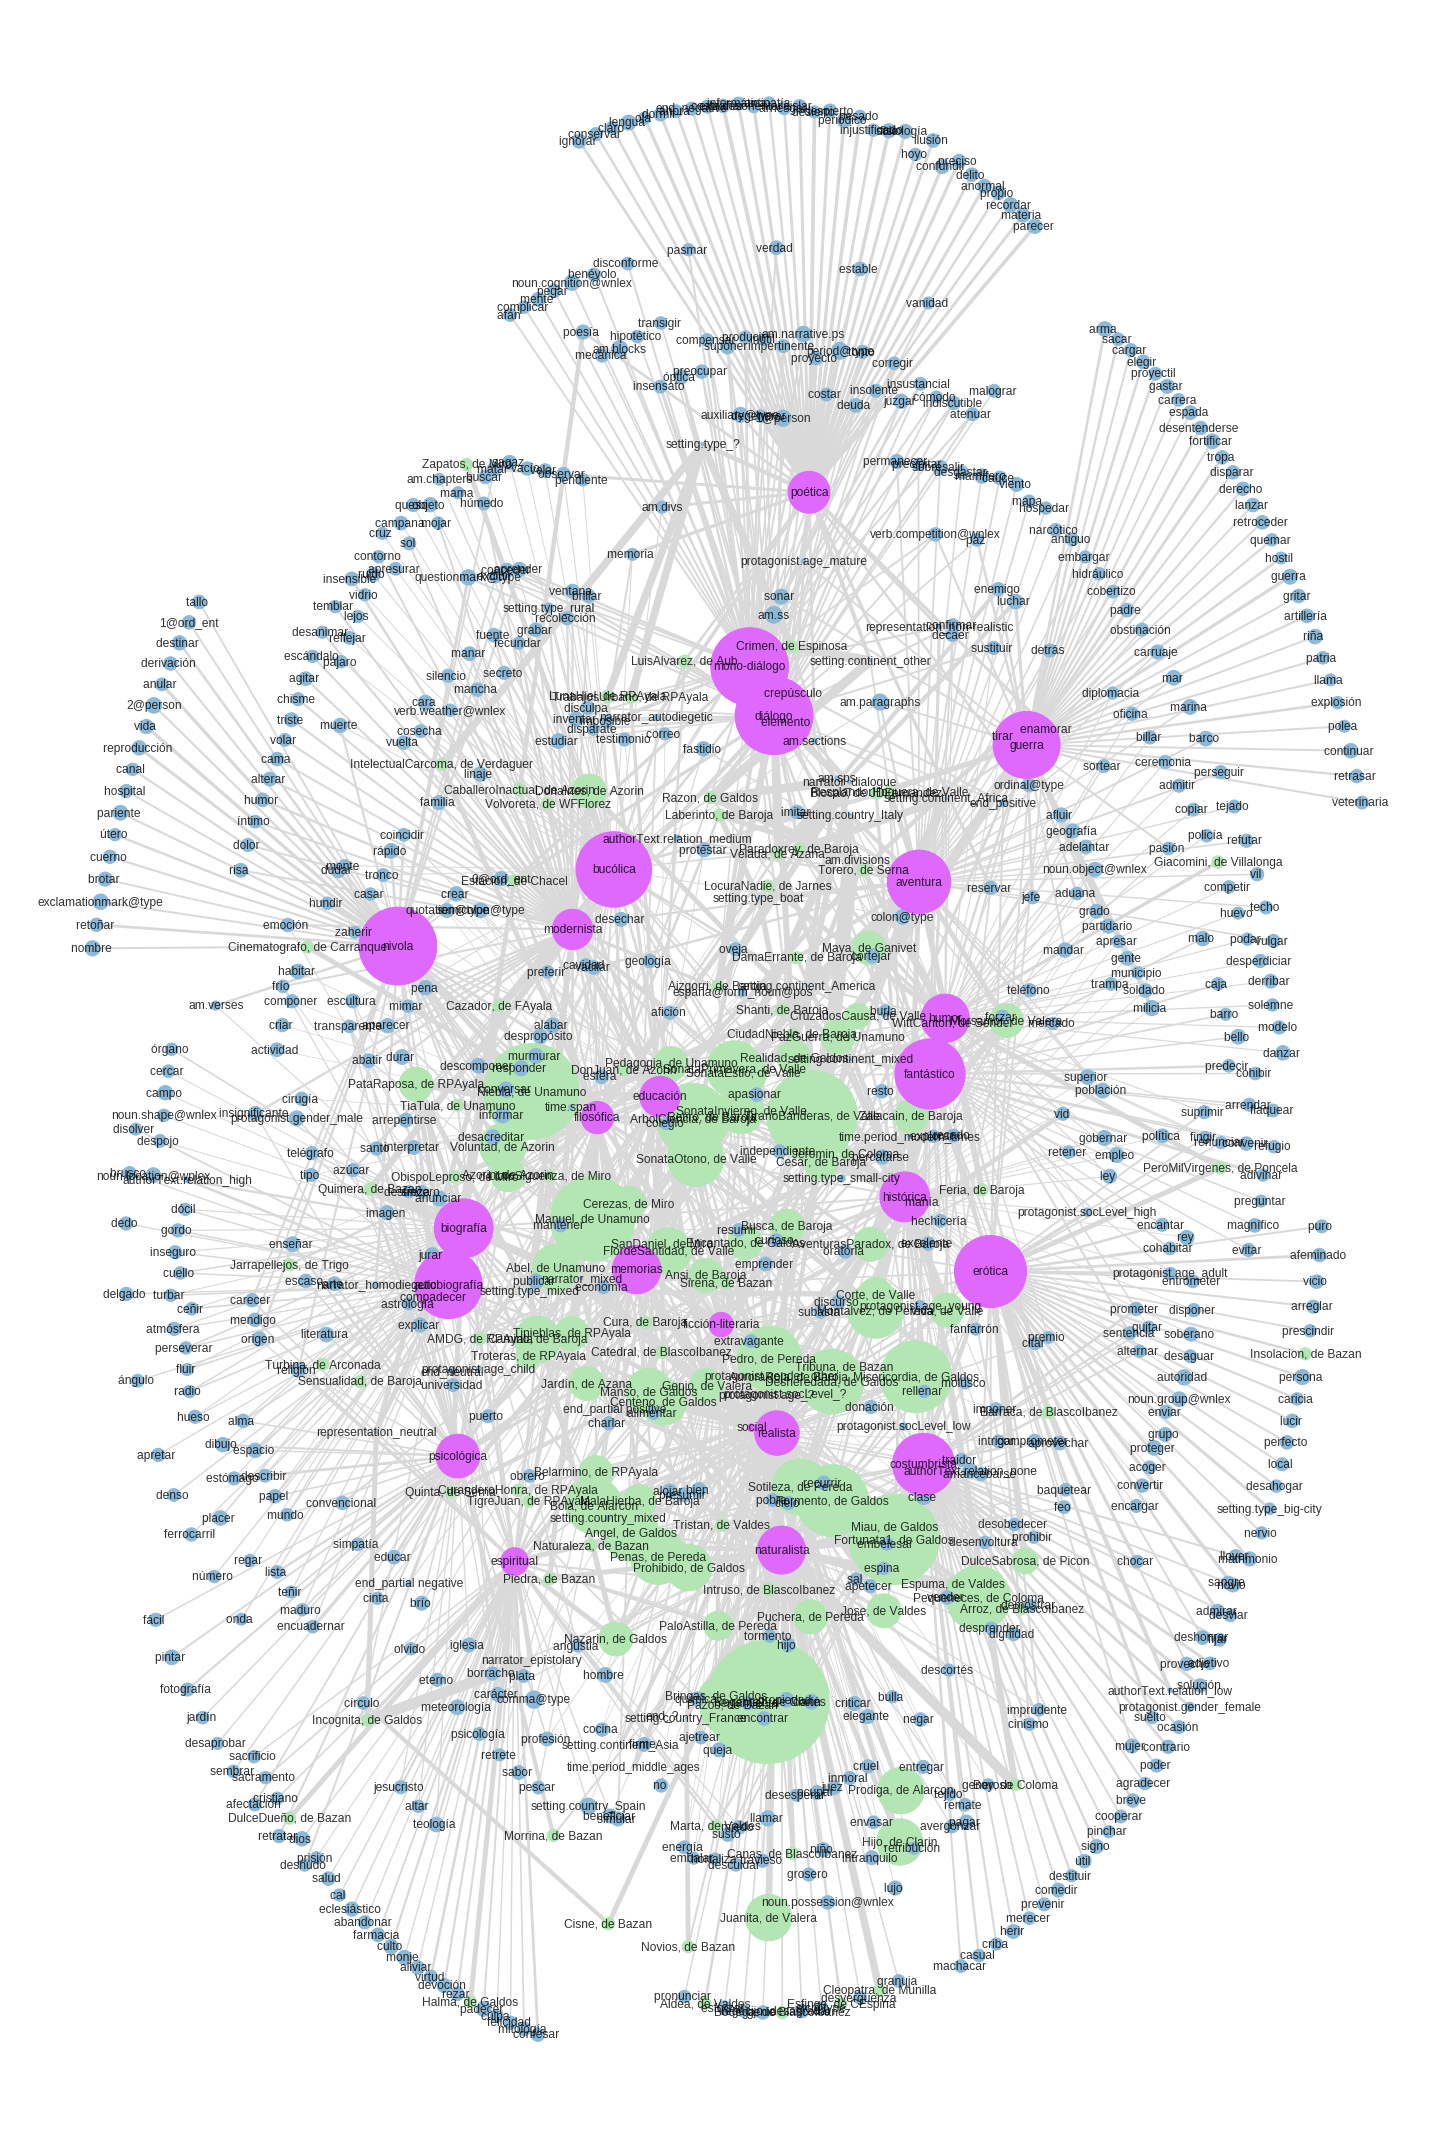

In [59]:
genre_as_graph.plot_graph(graph_canon_gp, labels_canon_list, weights_canon_list, colors_canon_list, sizes_canon_list, wdir)

In [60]:
amounts_of_features_per_subgenre = [50]
amounts_of_texts_per_subgenre = [50]
amounts_of_features_per_text = [50]

stds_deviation_of_feature_in_subgenre = [0.5]
stds_deviation_of_feature_in_text = [4]


nodes_df, edges_df, results_df, graph_gp, colors_list, sizes_list, weights_list, labels_list = genre_as_graph.make_complete_graph(bool_new_metadata_df, new_metadata_df, semantic_subgenres_lt,
                       selected_features_annotation_df, metadata_features_df,
                       results_features_zscores_df,
                       amounts_of_features_per_subgenre, amounts_of_texts_per_subgenre, amounts_of_features_per_text,
                       stds_deviation_of_feature_in_subgenre, stds_deviation_of_feature_in_text,
                       zscores_selected_features_df, texts_split, wdir, texts_without_genre_lt,
                       with_texts_without_genre = False)


(1428, 5)
(1017, 5)
50 50 50 0.5 4 -0.7 0.0 0.66 0.0


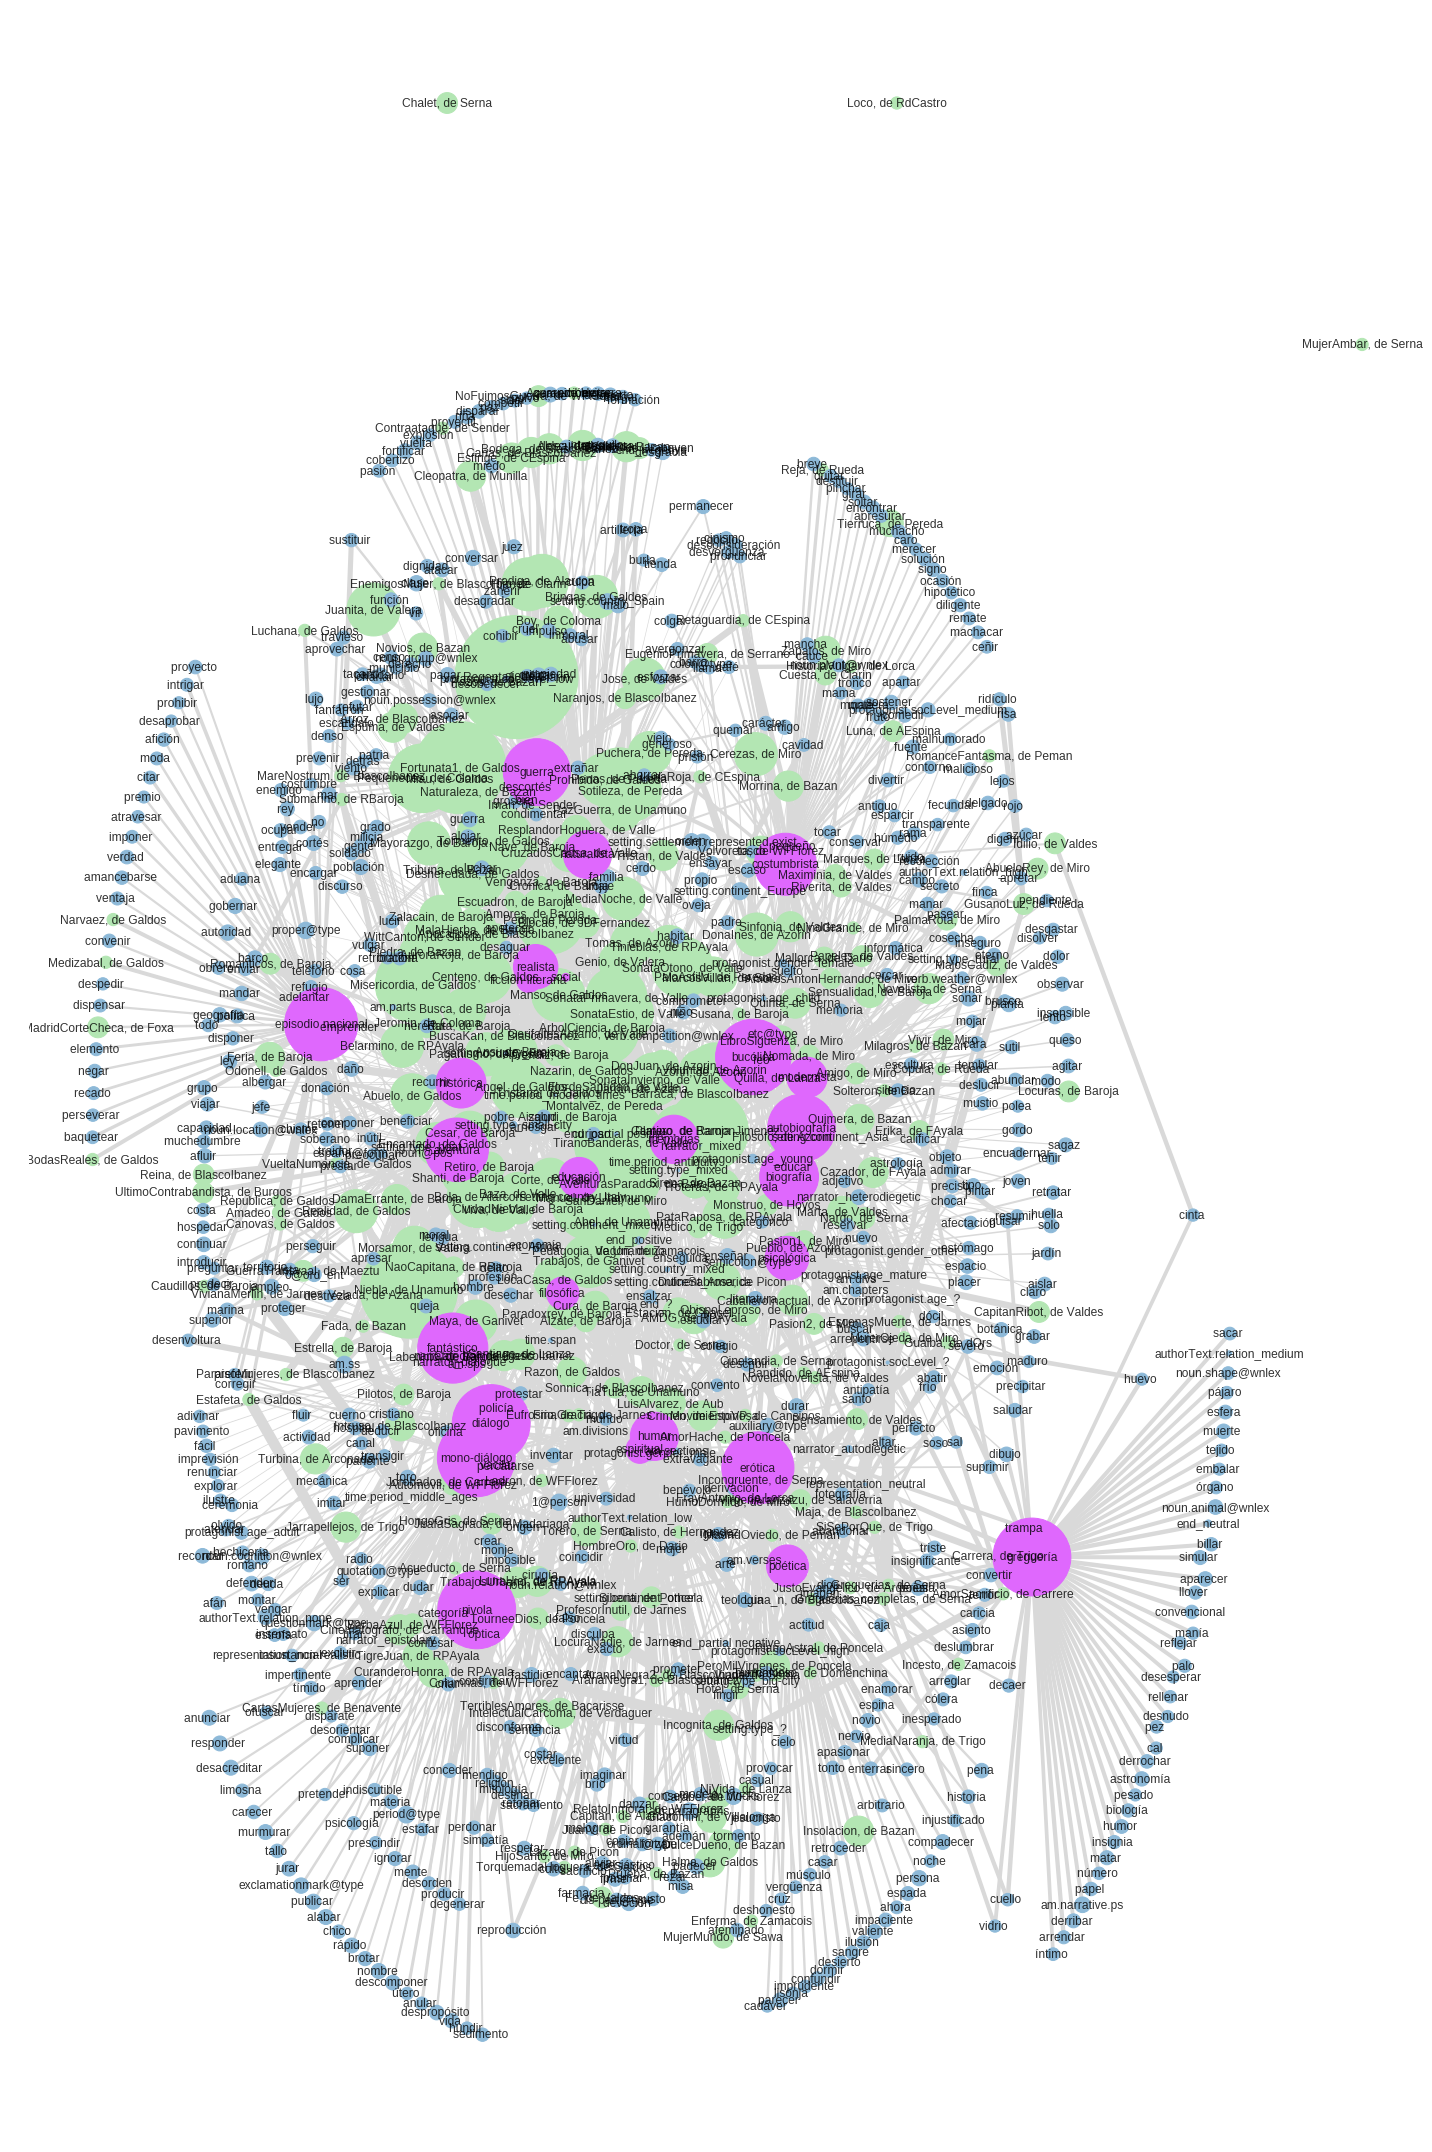

In [61]:
genre_as_graph.plot_graph(graph_gp, labels_list, weights_list, colors_list, sizes_list, wdir)

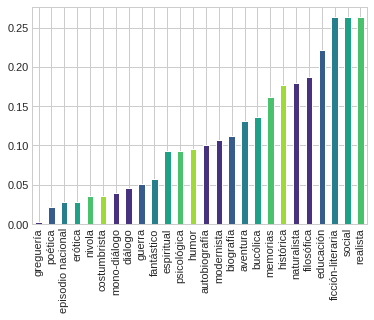

In [62]:
nodes_df.sort_values(by="eigenvector")["eigenvector"].plot.bar()

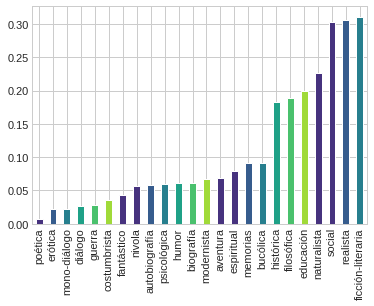

In [63]:
nodes_canon_df.sort_values(by="eigenvector")["eigenvector"].plot.bar()

In [100]:
nodes_canon_df

node       size      type              label  \
autobiografía          autobiografía  15.253763  subgenre      autobiografía   
aventura                    aventura  13.461649  subgenre           aventura   
biografía                  biografía  11.526165  subgenre          biografía   
bucólica                    bucólica  18.981362  subgenre           bucólica   
costumbrista            costumbrista  12.816487  subgenre       costumbrista   
diálogo                      diálogo  20.200000  subgenre            diálogo   
educación                  educación   5.432975  subgenre          educación   
erótica                      erótica  17.332616  subgenre            erótica   
espiritual                espiritual   2.565591  subgenre         espiritual   
fantástico                fantástico  16.400717  subgenre         fantástico   
ficción-literaria  ficción-literaria   1.992115  subgenre  ficción-literaria   
filosófica                filosófica   3.497491  subgenre         filosófica   
guerra                        guerra  14.967025  subgenre             guerra   
histórica                  histórica   8.300358  subgenre          histórica   
humor                          humor   7.726882  subgenre              humor   
memorias                    memorias   7.798566  subgenre           memorias   
modernista                modernista   5.432975  subgenre         modernista   
mono-diálogo            mono-diálogo  20.200000  subgenre       mono-diálogo   
naturalista              naturalista   7.655197  subgenre        naturalista   
nivola                        nivola  20.200000  subgenre             nivola   
poética                      poética   5.863082  subgenre            poética   
psicológica              psicológica   6.364875  subgenre        psicológica   
realista                    realista   6.579928  subgenre           realista   
social                        social   0.200000  subgenre             social   

                   mean.f1.ling-lit  litHist.pages  number.authors  \
autobiografía                 0.931       1.681818               6   
aventura                      0.906       1.968750               4   
biografía                     0.879       2.115385               8   
bucólica                      0.983       2.183333              11   
costumbrista                  0.897       1.950000               2   
diálogo                       1.000       1.142857               5   
educación                     0.794       2.346154              16   
erótica                       0.960       1.125000               3   
espiritual                    0.754       2.150000              11   
fantástico                    0.947       2.125000               6   
ficción-literaria             0.746       2.789362              20   
filosófica                    0.767       1.988889              17   
guerra                        0.927       1.583333               5   
histórica                     0.834       3.079545              16   
humor                         0.826       2.285714              10   
memorias                      0.827       2.250000              11   
modernista                    0.794       2.600000               8   
mono-diálogo                  1.000       1.166667               5   
naturalista                   0.825       3.394000              14   
nivola                        1.000       4.800000               1   
poética                       0.800       1.000000               2   
psicológica                   0.807       1.800000               5   
realista                      0.810       2.613592              27   
social                        0.721       2.662921              25   

                   number.texts  eigenvector  betweenness  degree  
autobiografía                11     0.057558     0.054844      61  
aventura                     16     0.068261     0.081351      66  
biografía                    13     0.061905     0.060228      63  
bucólica

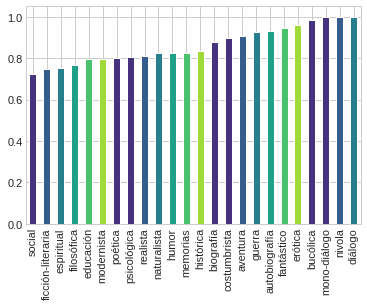

In [101]:
nodes_canon_df.sort_values(by="mean.f1.ling-lit")["mean.f1.ling-lit"].plot.bar()

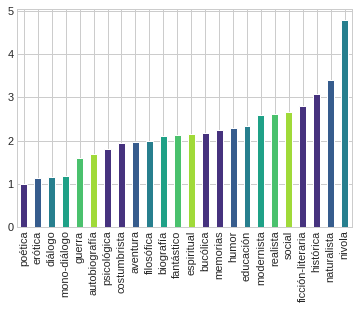

In [102]:
nodes_canon_df.sort_values(by="litHist.pages")["litHist.pages"].plot.bar()

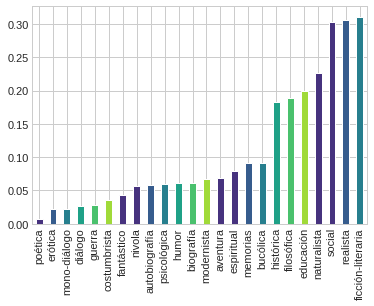

In [103]:

nodes_canon_df.sort_values(by="eigenvector")["eigenvector"].plot.bar()

In [64]:
graph_gp.remove_node("ne0120")

In [65]:
results_distance_nodes_lt = []

#all_pairs_dct = dict(nx.all_pairs_dijkstra_path_length(graph_gp))

for subgenre_st1 in nodes_df.sort_values(by="eigenvector", ascending=False).index.tolist():
    for subgenre_st2 in nodes_df.sort_values(by="eigenvector", ascending=False).index.tolist():
        if subgenre_st1 != subgenre_st2:
            #distance = nx.all_pairs_dijkstra_path_length(graph_gp, source=subgenre_st1, target = subgenre_st2)
            #distance = all_pairs_dct[subgenre_st1][subgenre_st2]
            #distance = nx.average_shortest_path_length(graph_gp,subgenre_st1,subgenre_st2)
            common_neighbors = len(list(nx.common_neighbors(graph_gp, subgenre_st1, subgenre_st2)))
            results_distance_nodes_lt.append([subgenre_st1,subgenre_st2, common_neighbors/(amounts_of_features_per_subgenre[0] + amounts_of_features_per_text[0])])
results_distance_nodes_df = pd.DataFrame(results_distance_nodes_lt, columns=["source","target","prop_common_neighbors"]).sort_values(by="prop_common_neighbors",ascending=False)
results_distance_nodes_df


source             target  prop_common_neighbors
0             realista             social                   0.63
25              social           realista                   0.63
310      autobiografía          biografía                   0.60
261          biografía      autobiografía                   0.60
1             realista  ficción-literaria                   0.59
50   ficción-literaria           realista                   0.59
51   ficción-literaria             social                   0.56
26              social  ficción-literaria                   0.56
125        naturalista           realista                   0.46
4             realista        naturalista                   0.46
126        naturalista             social                   0.43
29              social        naturalista                   0.43
493       mono-diálogo            diálogo                   0.43
468            diálogo       mono-diálogo                   0.43
283         modernista           bucólica                   0.42
210           bucólica         modernista                   0.42
152          histórica  ficción-literaria                   0.33
55   ficción-literaria          histórica                   0.33
75           educación           realista                   0.31
2             realista          educación                   0.31
27              social          educación                   0.30
76           educación             social                   0.30
52   ficción-literaria          educación                   0.30
77           educación  ficción-literaria                   0.30
158          histórica           aventura                   0.29
178           memorias          educación                   0.29
103         filosófica          educación                   0.29
231           aventura          histórica                   0.29
78           educación         filosófica                   0.29
81           educación           memorias                   0.29
..                 ...                ...                    ...
49              social          greguería                   0.00
583  episodio nacional           bucólica                   0.00
244           aventura       costumbrista                   0.00
445             guerra             nivola                   0.00
446             guerra            erótica                   0.00
248           aventura            poética                   0.00
249           aventura          greguería                   0.00
576  episodio nacional             social                   0.00
169          histórica       costumbrista                   0.00
448             guerra            poética                   0.00
572            erótica  episodio nacional                   0.00
449             guerra          greguería                   0.00
569            erótica       mono-diálogo                   0.00
567            erótica             guerra                   0.00
266          biografía             guerra                   0.00
145        naturalista             nivola                   0.00
272          biografía  episodio nacional                   0.00
24            realista          greguería                   0.00
464            diálogo        psicológica                   0.00
274          biografía          greguería                   0.00
149        naturalista          greguería                   0.00
552            erótica  ficción-literaria                   0.00
465            diálogo         espiritual                   0.00
550            erótica           realista                   0.00
549             nivola          greguería                   0.00
548             nivola            poética                   0.00
547             nivola  episodio nacional                   0.00
148        naturalista            poética                   0.00
545             nivola       costumbrista                   0.00
419         fantástico       costumbrista          

In [66]:
results_distance_nodes_df.loc[results_distance_nodes_df["source"]=="diálogo"].sort_values(by="prop_common_neighbors",ascending=False).head(5)[["target","prop_common_neighbors"]]

target  prop_common_neighbors
468  mono-diálogo                   0.43
454    filosófica                   0.09
466    fantástico                   0.09
463         humor                   0.07
458      bucólica                   0.06

In [67]:
results_distance_nodes_df.loc[results_distance_nodes_df["source"]=="autobiografía"].sort_values(by="prop_common_neighbors",ascending=False).head(5)

source       target  prop_common_neighbors
310  autobiografía    biografía                   0.60
307  autobiografía     memorias                   0.18
313  autobiografía  psicológica                   0.17
311  autobiografía   modernista                   0.15
303  autobiografía    educación                   0.14

In [68]:
nodes_df

node       size      type              label  \
autobiografía          autobiografía  15.253763  subgenre      autobiografía   
aventura                    aventura  13.461649  subgenre           aventura   
biografía                  biografía  11.526165  subgenre          biografía   
bucólica                    bucólica  18.981362  subgenre           bucólica   
costumbrista            costumbrista  12.816487  subgenre       costumbrista   
diálogo                      diálogo  20.200000  subgenre            diálogo   
educación                  educación   5.432975  subgenre          educación   
episodio nacional  episodio nacional  17.834409  subgenre  episodio nacional   
erótica                      erótica  17.332616  subgenre            erótica   
espiritual                espiritual   2.565591  subgenre         espiritual   
fantástico                fantástico  16.400717  subgenre         fantástico   
ficción-literaria  ficción-literaria   1.992115  subgenre  ficción-literaria   
filosófica                filosófica   3.497491  subgenre         filosófica   
greguería                  greguería  20.200000  subgenre          greguería   
guerra                        guerra  14.967025  subgenre             guerra   
histórica                  histórica   8.300358  subgenre          histórica   
humor                          humor   7.726882  subgenre              humor   
memorias                    memorias   7.798566  subgenre           memorias   
modernista                modernista   5.432975  subgenre         modernista   
mono-diálogo            mono-diálogo  20.200000  subgenre       mono-diálogo   
naturalista              naturalista   7.655197  subgenre        naturalista   
nivola                        nivola  20.200000  subgenre             nivola   
poética                      poética   5.863082  subgenre            poética   
psicológica              psicológica   6.364875  subgenre        psicológica   
realista                    realista   6.579928  subgenre           realista   
social                        social   0.200000  subgenre             social   

                   mean.f1.ling-lit  litHist.pages  number.authors  \
autobiografía                 0.931       1.284615              12   
aventura                      0.906       0.965306              15   
biografía                     0.879       1.436667              14   
bucólica                      0.983       1.102299              39   
costumbrista                  0.897       1.056250               4   
diálogo                       1.000       0.950000               8   
educación                     0.794       1.661429              24   
episodio nacional             0.967       0.227273               2   
erótica                       0.960       0.488235               9   
espiritual                    0.754       1.358824              15   
fantástico                    0.947       0.916667              14   
ficción-literaria             0.746       1.641053              33   
filosófica                    0.767       1.345455              33   
greguería                     1.000       0.200000               1   
guerra                        0.927       0.771429              12   
histórica                     0.834       1.459292              29   
humor                         0.826       1.004082              23   
memorias                      0.827       1.170909              21   
modernista                    0.794       1.611429              16   
mono-diálogo                  1.000       1.054545               7   
naturalista                   0.825       2.239759              22   
nivola                        1.000       4.800000               1   
poética                       0.800       1.880000               5   
psicológica                   0.807       1.580000              11   
realista                      0.810       1.495928              48   
social                        0.721       1.565405 

In [69]:
results_features_zscores_df.std(axis=1).round(2).sort_values()

ficción-literaria    0.28
social               0.29
realista             0.32
filosófica           0.34
educación            0.36
memorias             0.39
histórica            0.48
biografía            0.50
naturalista          0.51
humor                0.54
autobiografía        0.59
psicológica          0.60
espiritual           0.61
fantástico           0.64
bucólica             0.66
aventura             0.79
erótica              0.81
costumbrista         0.82
modernista           0.88
guerra               0.94
diálogo              0.95
episodio nacional    1.08
mono-diálogo         1.11
poética              1.56
nivola               1.79
greguería            2.16
dtype: float64

In [70]:
nodes_df.sort_values(by="mean.f1.ling-lit")

node       size      type              label  \
social                        social   0.200000  subgenre             social   
ficción-literaria  ficción-literaria   1.992115  subgenre  ficción-literaria   
espiritual                espiritual   2.565591  subgenre         espiritual   
filosófica                filosófica   3.497491  subgenre         filosófica   
educación                  educación   5.432975  subgenre          educación   
modernista                modernista   5.432975  subgenre         modernista   
poética                      poética   5.863082  subgenre            poética   
psicológica              psicológica   6.364875  subgenre        psicológica   
realista                    realista   6.579928  subgenre           realista   
naturalista              naturalista   7.655197  subgenre        naturalista   
humor                          humor   7.726882  subgenre              humor   
memorias                    memorias   7.798566  subgenre           memorias   
histórica                  histórica   8.300358  subgenre          histórica   
biografía                  biografía  11.526165  subgenre          biografía   
costumbrista            costumbrista  12.816487  subgenre       costumbrista   
aventura                    aventura  13.461649  subgenre           aventura   
guerra                        guerra  14.967025  subgenre             guerra   
autobiografía          autobiografía  15.253763  subgenre      autobiografía   
fantástico                fantástico  16.400717  subgenre         fantástico   
erótica                      erótica  17.332616  subgenre            erótica   
episodio nacional  episodio nacional  17.834409  subgenre  episodio nacional   
bucólica                    bucólica  18.981362  subgenre           bucólica   
greguería                  greguería  20.200000  subgenre          greguería   
mono-diálogo            mono-diálogo  20.200000  subgenre       mono-diálogo   
nivola                        nivola  20.200000  subgenre             nivola   
diálogo                      diálogo  20.200000  subgenre            diálogo   

                   mean.f1.ling-lit  litHist.pages  number.authors  \
social                        0.721       1.565405              50   
ficción-literaria             0.746       1.641053              33   
espiritual                    0.754       1.358824              15   
filosófica                    0.767       1.345455              33   
educación                     0.794       1.661429              24   
modernista                    0.794       1.611429              16   
poética                       0.800       1.880000               5   
psicológica                   0.807       1.580000              11   
realista                      0.810       1.495928              48   
naturalista                   0.825       2.239759              22   
humor                         0.826       1.004082              23   
memorias                      0.827       1.170909              21   
histórica                     0.834       1.459292              29   
biografía                     0.879       1.436667              14   
costumbrista                  0.897       1.056250               4   
aventura                      0.906       0.965306              15   
guerra                        0.927       0.771429              12   
autobiografía                 0.931       1.284615              12   
fantástico                    0.947       0.916667              14   
erótica                       0.960       0.488235               9   
episodio nacional             0.967       0.227273               2   
bucólica                      0.983       1.102299              39   
greguería                     1.000       0.200000               1   
mono-diálogo                  1.000       1.054545               7   
nivola                        1.000       4.800000               1   
diálogo                       1.000       0.950000 

In [71]:
nodes_df.sort_values(by="litHist.pages")

node       size      type              label  \
greguería                  greguería  20.200000  subgenre          greguería   
episodio nacional  episodio nacional  17.834409  subgenre  episodio nacional   
erótica                      erótica  17.332616  subgenre            erótica   
guerra                        guerra  14.967025  subgenre             guerra   
fantástico                fantástico  16.400717  subgenre         fantástico   
diálogo                      diálogo  20.200000  subgenre            diálogo   
aventura                    aventura  13.461649  subgenre           aventura   
humor                          humor   7.726882  subgenre              humor   
mono-diálogo            mono-diálogo  20.200000  subgenre       mono-diálogo   
costumbrista            costumbrista  12.816487  subgenre       costumbrista   
bucólica                    bucólica  18.981362  subgenre           bucólica   
memorias                    memorias   7.798566  subgenre           memorias   
autobiografía          autobiografía  15.253763  subgenre      autobiografía   
filosófica                filosófica   3.497491  subgenre         filosófica   
espiritual                espiritual   2.565591  subgenre         espiritual   
biografía                  biografía  11.526165  subgenre          biografía   
histórica                  histórica   8.300358  subgenre          histórica   
realista                    realista   6.579928  subgenre           realista   
social                        social   0.200000  subgenre             social   
psicológica              psicológica   6.364875  subgenre        psicológica   
modernista                modernista   5.432975  subgenre         modernista   
ficción-literaria  ficción-literaria   1.992115  subgenre  ficción-literaria   
educación                  educación   5.432975  subgenre          educación   
poética                      poética   5.863082  subgenre            poética   
naturalista              naturalista   7.655197  subgenre        naturalista   
nivola                        nivola  20.200000  subgenre             nivola   

                   mean.f1.ling-lit  litHist.pages  number.authors  \
greguería                     1.000       0.200000               1   
episodio nacional             0.967       0.227273               2   
erótica                       0.960       0.488235               9   
guerra                        0.927       0.771429              12   
fantástico                    0.947       0.916667              14   
diálogo                       1.000       0.950000               8   
aventura                      0.906       0.965306              15   
humor                         0.826       1.004082              23   
mono-diálogo                  1.000       1.054545               7   
costumbrista                  0.897       1.056250               4   
bucólica                      0.983       1.102299              39   
memorias                      0.827       1.170909              21   
autobiografía                 0.931       1.284615              12   
filosófica                    0.767       1.345455              33   
espiritual                    0.754       1.358824              15   
biografía                     0.879       1.436667              14   
histórica                     0.834       1.459292              29   
realista                      0.810       1.495928              48   
social                        0.721       1.565405              50   
psicológica                   0.807       1.580000              11   
modernista                    0.794       1.611429              16   
ficción-literaria             0.746       1.641053              33   
educación                     0.794       1.661429              24   
poética                       0.800       1.880000               5   
naturalista                   0.825       2.239759              22   
nivola                        1.000       4.800000 

In [72]:
results_features_zscores_canon_df

am.divs  1@person  am.verses    am.sps  2@person  \
autobiografía      0.405149 -0.824451   0.894206 -0.213024 -1.955907   
aventura           0.856148 -0.280644   0.055706 -0.424912 -0.673650   
biografía          0.384020 -0.757179   1.134166 -0.302010 -1.744074   
costumbrista      -2.220087 -0.928937  -2.490705 -0.791430  0.725326   
diálogo           -0.053324  1.837193   0.112397  3.175736  1.139849   
educación         -0.256161 -0.343854  -0.157929 -0.310946 -0.202273   
erótica           -0.146750  0.517283  -0.019860 -0.166728  0.723258   
espiritual        -0.691276 -0.006762  -0.276679 -0.245148  0.859042   
fantástico         0.955594  0.588040  -0.676623  1.126323  0.915274   
filosófica        -0.134678 -0.336050   0.188650 -0.054666 -0.454790   
guerra            -0.727046 -1.491856   1.669033 -0.791430 -0.724704   
histórica         -0.221222 -0.461314  -0.193323 -0.514545 -0.194920   
humor              0.355937 -0.879579   0.156442 -0.225639 -0.743363   
memorias           0.301917  1.023252  -0.560347 -0.470907 -0.510309   
modernista         0.002903 -0.378433  -0.054010 -0.327589 -0.708294   
naturalista       -1.579823 -0.814342  -1.486982 -0.271024  0.118793   
nivola             0.407746  0.933155   2.488281 -0.108833  2.154866   
poética            2.970674  2.455912  -0.290127 -0.791430  1.543246   
psicológica        0.602371 -0.063119   1.047985 -0.441149 -1.176120   
realista          -0.873883 -0.581261  -0.732463 -0.332102 -0.009489   
social            -0.689519 -0.601025  -0.764444 -0.115008  0.092192   
bucólica           1.150315 -0.220976   0.251118 -0.096141 -0.411590   
mono-diálogo      -0.381197  1.939215   0.100337  2.859549  0.981295   
ficción-literaria -0.417806 -0.324269  -0.394831 -0.166944  0.256340   

                   am.paragraphs    am.pds  abandonar@mariax  am.blocks  \
autobiografía          -0.118535  0.113677         -1.261084  -0.407322   
aventura                1.868310  0.577747         -1.530275   1.297371   
biografía               0.077329  0.163843         -0.728689  -0.246264   
costumbrista           -0.928311  0.506252          1.588823  -1.283949   
diálogo                -0.073082 -2.310477          0.178571   2.329857   
educación              -0.345845  0.294397         -0.047384  -0.623851   
erótica                 0.203749  0.490284          1.436489  -0.257364   
espiritual             -0.803032  0.437913          1.320447  -0.992575   
fantástico             -0.274872 -0.138413         -0.161560   0.489212   
filosófica             -0.296646  0.255260         -0.880773  -0.325027   
guerra                  1.882559  0.666184         -1.305146   1.169889   
histórica              -0.001980  0.393574         -0.352692  -0.300235   
humor                   1.388092  0.513449         -0.795970   0.951616   
memorias               -0.118633  0.381434          0.963357  -0.485780   
modernista              0.904362  0.500920         -0.451041   0.309042   
naturalista            -1.234223  0.291495          0.730839  -1.345253   
nivola                  1.667683  0.850629          0.071948   1.075654   
poética                -1.859566 -2.350509          1.849560  -1.254356   
psicológica            -1.059068  0.289367         -1.724914  -1.083432   
realista               -0.503597  0.315671          0.379387  -0.701094   
social                 -0.368277  0.280285          0.058613  -0.500954   
bucólica                1.015120  0.064985         -0.029917   0.891038   
mono-diálogo           -1.022828 -2.909779          0.822073   1.496808   
ficción-literaria       0.001294  0.321810         -0.130661  -0.203030   

                   am.chapters           ...             \
autobiografía         0.382179           ...              
aventura              1.357346           ...              
biografía             0.452249           ...              
costumbrista         -1.926491           ...              
diálogo              -0.711134           ...    

In [87]:
new_metadata_canon_df.loc[new_metadata_canon_df["nivola"]>0]

idno author.name      title  year supergenre   genre  \
ne0069  ne0069     Unamuno       Abel  1917  narrative  novela   
ne0070  ne0070     Unamuno  Pedagogia  1902  narrative  novela   
ne0072  ne0072     Unamuno    TiaTula  1921  narrative  novela   
ne0073  ne0073     Unamuno     Niebla  1914  narrative  novela   
ne0074  ne0074     Unamuno     Manuel  1931  narrative  novela   

       subgenre.cligs.important author.country  author.viaf author.bne  \
ne0069            philosophical          Spain   88844103.0  XX1139151   
ne0070            philosophical          Spain   88844103.0  XX1139151   
ne0072            bildungsroman          Spain   88844103.0  XX1139151   
ne0073            philosophical          Spain   88844103.0  XX1139151   
ne0074            philosophical          Spain   88844103.0  XX1139151   

               ...         naturalista    nivola poética psicológica  \
ne0069         ...                 0.0  0.285714     0.0    0.142857   
ne0070         ...                 0.0  0.166667     0.0    0.000000   
ne0072         ...                 0.0  0.200000     0.0    0.000000   
ne0073         ...                 0.0  0.500000     0.0    0.000000   
ne0074         ...                 0.0  0.200000     0.0    0.000000   

        realista    social  bucólica mono-diálogo ficción-literaria  \
ne0069  0.142857  0.285714  0.142857          0.0          0.142857   
ne0070  0.000000  0.166667  0.166667          0.0          0.166667   
ne0072  0.000000  0.200000  0.200000          0.0          0.200000   
ne0073  0.000000  0.000000  0.000000          0.0          0.166667   
ne0074  0.000000  0.400000  0.200000          0.0          0.200000   

       mean.prop.subgenres  
ne0069            0.065934  
ne0070            0.038462  
ne0072            0.053846  
ne0073            0.038462  
ne0074            0.076923  

[5 rows x 205 columns]

In [91]:
nodes_canon_df

node       size      type              label  \
autobiografía          autobiografía  15.253763  subgenre      autobiografía   
aventura                    aventura  13.461649  subgenre           aventura   
biografía                  biografía  11.526165  subgenre          biografía   
bucólica                    bucólica  18.981362  subgenre           bucólica   
costumbrista            costumbrista  12.816487  subgenre       costumbrista   
diálogo                      diálogo  20.200000  subgenre            diálogo   
educación                  educación   5.432975  subgenre          educación   
erótica                      erótica  17.332616  subgenre            erótica   
espiritual                espiritual   2.565591  subgenre         espiritual   
fantástico                fantástico  16.400717  subgenre         fantástico   
ficción-literaria  ficción-literaria   1.992115  subgenre  ficción-literaria   
filosófica                filosófica   3.497491  subgenre         filosófica   
guerra                        guerra  14.967025  subgenre             guerra   
histórica                  histórica   8.300358  subgenre          histórica   
humor                          humor   7.726882  subgenre              humor   
memorias                    memorias   7.798566  subgenre           memorias   
modernista                modernista   5.432975  subgenre         modernista   
mono-diálogo            mono-diálogo  20.200000  subgenre       mono-diálogo   
naturalista              naturalista   7.655197  subgenre        naturalista   
nivola                        nivola  20.200000  subgenre             nivola   
poética                      poética   5.863082  subgenre            poética   
psicológica              psicológica   6.364875  subgenre        psicológica   
realista                    realista   6.579928  subgenre           realista   
social                        social   0.200000  subgenre             social   

                   mean.f1.ling-lit  litHist.pages  number.authors  \
autobiografía                 0.931       1.681818               6   
aventura                      0.906       1.968750               4   
biografía                     0.879       2.115385               8   
bucólica                      0.983       2.183333              11   
costumbrista                  0.897       1.950000               2   
diálogo                       1.000       1.142857               5   
educación                     0.794       2.346154              16   
erótica                       0.960       1.125000               3   
espiritual                    0.754       2.150000              11   
fantástico                    0.947       2.125000               6   
ficción-literaria             0.746       2.789362              20   
filosófica                    0.767       1.988889              17   
guerra                        0.927       1.583333               5   
histórica                     0.834       3.079545              16   
humor                         0.826       2.285714              10   
memorias                      0.827       2.250000              11   
modernista                    0.794       2.600000               8   
mono-diálogo                  1.000       1.166667               5   
naturalista                   0.825       3.394000              14   
nivola                        1.000       4.800000               1   
poética                       0.800       1.000000               2   
psicológica                   0.807       1.800000               5   
realista                      0.810       2.613592              27   
social                        0.721       2.662921              25   

                   number.texts  eigenvector  betweenness  degree  
autobiografía                11     0.057558     0.054844      61  
aventura                     16     0.068261     0.081351      66  
biografía                    13     0.061905     0.060228      63  
bucólica

In [ ]:
"\nlitHist.pages: " + str(nodes_df.loc["realista"]["litHist.pages"].round(2), nodes_canon_df.loc["realista"]["litHist.pages"].round(2))

In [99]:
total_description = ""
for subgenre_st in nodes_df.sort_values(by="eigenvector", ascending=False).index.tolist():
    subgenre_description = "\n\n----------------\n" + subgenre_st +"\n----------------\n"
    subgenre_description += "\neigenvector: " + str(nodes_df.loc[subgenre_st]["eigenvector"].round(2))
    subgenre_description +=  "\nstd.zscores.features: " + str(results_features_zscores_df.loc[subgenre_st].std().round(2))

    try:
        subgenre_description +=  "\nnumber.texts: " + str(nodes_df.loc[subgenre_st]["number.texts"]) +", "+  str(nodes_canon_df.loc[subgenre_st]["number.texts"])
        subgenre_description +=  "\nnumber.authors: " + str(nodes_df.loc[subgenre_st]["number.authors"]) +", "+  str( nodes_canon_df.loc[subgenre_st]["number.authors"])
        subgenre_description +=  "\nmean.f1.ling-lit: " + str(nodes_df.loc[subgenre_st]["mean.f1.ling-lit"]) +", "+  str( nodes_canon_df.loc[subgenre_st]["mean.f1.ling-lit"])
        subgenre_description +=  "\nlitHist.pages: " + str(nodes_df.loc[subgenre_st]["litHist.pages"].round(2)) +", "+  str( nodes_canon_df.loc[subgenre_st]["litHist.pages"].round(2))
        
    except:
        subgenre_description +=  "\nnumber.texts: " + str(nodes_df.loc[subgenre_st]["number.texts"].round(2))
        subgenre_description +=  "\nnumber.authors: " + str(nodes_df.loc[subgenre_st]["number.authors"].round(2))
        subgenre_description +=  "\nmean.f1.ling-lit: " + str(nodes_df.loc[subgenre_st]["mean.f1.ling-lit"].round(2))
        subgenre_description +=  "\nlitHist.pages: " + str(nodes_df.loc[subgenre_st]["litHist.pages"].round(2))

    subgenre_description +=  "\n"
    subgenre_description +=  "\n"
    subgenre_description +=  "\n"
    subgenre_description +=  "positive linguistic features \n"
    subgenre_description +=  "----------------------------\n"
    #try:
    for feature_st, zscore in results_features_zscores_df[selected_features_annotation_df.columns.tolist()].loc[subgenre_st].sort_values(ascending=False)[0:20].items():
        if subgenre_st in results_features_zscores_canon_df.index.tolist() and results_features_zscores_canon_df.loc[subgenre_st,feature_st] > 0:
            subgenre_description += feature_st +  "\t" + str(round(zscore,2)) + "\n"
        else:
            subgenre_description += feature_st +  "\t" + str(round(zscore,2)) + " (only in CoNSSA) \n"
    """
    except:
        subgenre_description +=  "only from CoNSSA\n"
        print(results_features_zscores_df[selected_features_annotation_df.columns.tolist()].loc[subgenre_st].sort_values(ascending=False)[0:20])
        subgenre_description += results_features_zscores_df[selected_features_annotation_df.columns.tolist()].loc[subgenre_st].sort_values(ascending=False)[0:20]
    """
    subgenre_description +=  "\n"
    subgenre_description +=  "positive metadata \n"
    subgenre_description +=  "----------------------------\n"
    #try:
    for feature_st, zscore in results_features_zscores_df[zscores_metadata_features_df.columns.tolist()].loc[subgenre_st].sort_values(ascending=False)[0:20].items():
        if subgenre_st in results_features_zscores_canon_df.index.tolist() and results_features_zscores_canon_df.loc[subgenre_st,feature_st] > 0:
            subgenre_description +=  feature_st + "\t" + str(round(zscore,2)) + "\n"
        else:
            subgenre_description += feature_st +  "\t" + str(round(zscore,2)) + " (only in CoNSSA) \n"
    """except:
        subgenre_description +=  "only from CoNSSA\n"
        print(results_features_zscores_df[zscores_metadata_features_df.columns.tolist()].loc[subgenre_st].sort_values(ascending=False)[0:20])
        subgenre_description +=  results_features_zscores_df[zscores_metadata_features_df.columns.tolist()].loc[subgenre_st].sort_values(ascending=False)[0:20]
    """
    subgenre_description +=  "\n"
    subgenre_description +=  "negative linguistic features \n"
    subgenre_description +=  "----------------------------\n"
    #try:
    for feature_st, zscore in results_features_zscores_df[selected_features_annotation_df.columns.tolist()].loc[subgenre_st].sort_values(ascending=False)[-5:].items():
        if subgenre_st in results_features_zscores_canon_df.index.tolist() and results_features_zscores_canon_df.loc[subgenre_st,feature_st] < 0:
            subgenre_description +=  feature_st + "\t" + str(round(zscore,2)) + "\n"
        else:
            subgenre_description += feature_st +  "\t" + str(round(zscore,2)) + " (only in CoNSSA) \n"
    """except:
        subgenre_description +=  "only from CoNSSA\n"
        subgenre_description +=  results_features_zscores_df[selected_features_annotation_df.columns.tolist()].loc[subgenre_st].sort_values(ascending=False)[-5:]
    """
    subgenre_description +=  "\n"
    subgenre_description +=  "negative metadata \n"
    subgenre_description +=  "----------------------------\n"
    #try:
    for feature_st, zscore in results_features_zscores_df[zscores_metadata_features_df.columns.tolist()].loc[subgenre_st].sort_values(ascending=False)[-5:].items():
        if subgenre_st in results_features_zscores_canon_df.index.tolist() and results_features_zscores_canon_df.loc[subgenre_st,feature_st] < 0:
            subgenre_description +=   feature_st + "\t" + str(round(zscore,2)) + "\n"
        else:
            subgenre_description += feature_st +  "\t" + str(round(zscore,2)) + " (only in CoNSSA) \n"
    """except:
        subgenre_description +=  "only from CoNSSA\n"
        subgenre_description +=  results_features_zscores_df[zscores_metadata_features_df.columns.tolist()].loc[subgenre_st].sort_values(ascending=False)[-5:]
    """

    subgenre_description += "\n"
    subgenre_description +=  "texts most frequently labeled as part of this subgenre\n"
    subgenre_description +=  "----------------------------\n"
    subgenre_description += str(edges_df.loc[(edges_df["source"] == subgenre_st) & (edges_df["type"] == "subgenre-novel")].sort_values(by="weight",ascending=False).head(10)[["target-label","weight","title.main"]])

    subgenre_description +=  "\n"
    subgenre_description +=  "closeness to other subgenres \n"
    subgenre_description +=  "----------------------------\n"
    subgenre_description += str(results_distance_nodes_df.loc[results_distance_nodes_df["source"] == subgenre_st].sort_values(by="prop_common_neighbors",ascending=False).head(5)[["target","prop_common_neighbors"]])
    
    print(subgenre_description)
    with open (wdir + subgenre_st+"_description.txt", "w", encoding="utf-8") as fout:
                fout.write(subgenre_description)
    total_description += subgenre_description
    
with open (wdir + "complete_description.txt", "w", encoding="utf-8") as fout:
            fout.write(total_description)
        



----------------
realista
----------------

eigenvector: 0.26
std.zscores.features: 0.32
number.texts: 221, 103
number.authors: 48, 27
mean.f1.ling-lit: 0.81, 0.81
litHist.pages: 1.5, 2.61


positive linguistic features 
----------------------------
desobedecer@mariax	1.17
salud@mariax	1.14
propiedad@mariax	1.14
zaherir@mariax	1.1
criticar@mariax	1.1
pagar@mariax	0.99
impulso@mariax	0.95
descortés@mariax	0.95
desagradar@mariax	0.92
bien@mariax	0.91
grosero@mariax	0.9
retribución@mariax	0.9
comprometer@mariax	0.89
abusar@mariax	0.88
prestar@mariax	0.88
lujo@mariax	0.87
lucir@mariax	0.87
ensalzar@mariax	0.87
avergonzar@mariax	0.87
no@mariax	0.86

positive metadata 
----------------------------
protagonist.socLevel_low	1.32
setting.continent_Europe	0.87
representation_realistic	0.76
setting.country_Spain	0.68
narrator_heterodiegetic	0.54
protagonist.gender_female	0.52
time.period_contemporary	0.5
protagonist.socLevel_high	0.47
setting.settlement.represented.exist	0.47
authorText.relatio



----------------
bucólica
----------------

eigenvector: 0.14
std.zscores.features: 0.66
number.texts: 87, 30
number.authors: 39, 11
mean.f1.ling-lit: 0.983, 0.983
litHist.pages: 1.1, 2.18


positive linguistic features 
----------------------------
secreto@mariax	1.34
llama@mariax	1.19
quemar@mariax	1.1
ruido@mariax	1.08
silencio@mariax	1.07
escultura@mariax	1.06
am.divs	1.04
cercar@mariax	1.03
arrepentirse@mariax	1.03
madera@mariax	1.0
am.chapters	1.0
cauce@mariax	0.99
campo@mariax	0.97
mojar@mariax	0.97
húmedo@mariax	0.95
verb.weather@wnlex	0.95
fecundar@mariax	0.93
fuente@mariax	0.92
memoria@mariax	0.92
santo@mariax	0.91

positive metadata 
----------------------------
end_?	1.43 (only in CoNSSA) 
setting.type_rural	1.19
time.period_antiquity	1.08
protagonist.age_mature	1.06
setting.continent_Asia	1.04 (only in CoNSSA) 
setting.country_Italy	0.91
time.period_middle_ages	0.74 (only in CoNSSA) 
setting.country_France	0.72 (only in CoNSSA) 
protagonist.socLevel_?	0.66 (only in CoNSS



----------------
diálogo
----------------

eigenvector: 0.05
std.zscores.features: 0.95
number.texts: 14, 7
number.authors: 8, 5
mean.f1.ling-lit: 1.0, 1.0
litHist.pages: 0.95, 1.14


positive linguistic features 
----------------------------
am.sps	3.56
conceder@mariax	2.52
1@person	2.18
am.ss	2.17
impertinente@mariax	2.11
inútil@mariax	2.09
suponer@mariax	2.04
aprender@mariax	2.02
insensato@mariax	1.99
vengar@mariax	1.97
disparate@mariax	1.96
noun.cognition@wnlex	1.96
óptica@mariax	1.95
am.divisions	1.93
period@type	1.93
desorientar@mariax	1.86
atenuar@mariax	1.85
insustancial@mariax	1.83
simpatía@mariax	1.83 (only in CoNSSA) 
ser@mariax	1.77

positive metadata 
----------------------------
narrator_dialogue	3.64
narrator_epistolary	2.67 (only in CoNSSA) 
time.period_middle_ages	2.04 (only in CoNSSA) 
setting.continent_Africa	1.7
end_positive	1.66
protagonist.age_adult	1.04
setting.continent_other	1.01
protagonist.gender_female	0.8
authorText.relation_none	0.68
protagonist.socLevel

In [74]:
nodes_df.sort_values(by="eigenvector", ascending=False)

node       size      type              label  \
realista                    realista   6.579928  subgenre           realista   
social                        social   0.200000  subgenre             social   
ficción-literaria  ficción-literaria   1.992115  subgenre  ficción-literaria   
educación                  educación   5.432975  subgenre          educación   
filosófica                filosófica   3.497491  subgenre         filosófica   
naturalista              naturalista   7.655197  subgenre        naturalista   
histórica                  histórica   8.300358  subgenre          histórica   
memorias                    memorias   7.798566  subgenre           memorias   
bucólica                    bucólica  18.981362  subgenre           bucólica   
aventura                    aventura  13.461649  subgenre           aventura   
biografía                  biografía  11.526165  subgenre          biografía   
modernista                modernista   5.432975  subgenre         modernista   
autobiografía          autobiografía  15.253763  subgenre      autobiografía   
humor                          humor   7.726882  subgenre              humor   
psicológica              psicológica   6.364875  subgenre        psicológica   
espiritual                espiritual   2.565591  subgenre         espiritual   
fantástico                fantástico  16.400717  subgenre         fantástico   
guerra                        guerra  14.967025  subgenre             guerra   
diálogo                      diálogo  20.200000  subgenre            diálogo   
mono-diálogo            mono-diálogo  20.200000  subgenre       mono-diálogo   
costumbrista            costumbrista  12.816487  subgenre       costumbrista   
nivola                        nivola  20.200000  subgenre             nivola   
erótica                      erótica  17.332616  subgenre            erótica   
episodio nacional  episodio nacional  17.834409  subgenre  episodio nacional   
poética                      poética   5.863082  subgenre            poética   
greguería                  greguería  20.200000  subgenre          greguería   

                   mean.f1.ling-lit  litHist.pages  number.authors  \
realista                      0.810       1.495928              48   
social                        0.721       1.565405              50   
ficción-literaria             0.746       1.641053              33   
educación                     0.794       1.661429              24   
filosófica                    0.767       1.345455              33   
naturalista                   0.825       2.239759              22   
histórica                     0.834       1.459292              29   
memorias                      0.827       1.170909              21   
bucólica                      0.983       1.102299              39   
aventura                      0.906       0.965306              15   
biografía                     0.879       1.436667              14   
modernista                    0.794       1.611429              16   
autobiografía                 0.931       1.284615              12   
humor                         0.826       1.004082              23   
psicológica                   0.807       1.580000              11   
espiritual                    0.754       1.358824              15   
fantástico                    0.947       0.916667              14   
guerra                        0.927       0.771429              12   
diálogo                       1.000       0.950000               8   
mono-diálogo                  1.000       1.054545               7   
costumbrista                  0.897       1.056250               4   
nivola                        1.000       4.800000               1   
erótica                       0.960       0.488235               9   
episodio nacional             0.967       0.227273               2   
poética                       0.800       1.880000               5   
greguería                     1.000       0.200000 

In [75]:
edges_df.loc[(edges_df["source"] == "ficción-literaria") & (edges_df["type"] == "subgenre-novel")].sort_values(by="weight",ascending=False)[["target-label","weight","title.main"]]

target-label    weight  \
809        MalaHierba, de Baroja  3.333333   
812             Tomas, de Azorin  3.333333   
799  AventurasParadox, de Baroja  3.333333   
802             Busca, de Baroja  3.333333   
789           Centeno, de Galdos  3.333333   
806        PazGuerra, de Unamuno  3.333333   
807              Ansi, de Baroja  3.333333   
810         Mayorazgo, de Baroja  3.333333   
797        AuroraRoja, de Baroja  3.333333   
815               Baza, de Valle  3.333333   
813              Corte, de Valle  2.500000   
814               Viva, de Valle  2.500000   
817         MediaNoche, de Valle  2.500000   
795            Camino, de Baroja  2.500000   
803        Tinieblas, de RPAyala  2.500000   
804             Cesar, de Baroja  2.500000   
777      ArbolCiencia, de Baroja  2.500000   
788         Prohibido, de Galdos  2.500000   
786              Miau, de Galdos  2.500000   
775      Misericordia, de Galdos  2.500000   
798          Zalacain, de Baroja  2.500000   
776          Tormento, de Galdos  2.500000   
811          Tristana, de Galdos  2.500000   
780             Angel, de Galdos  2.500000   
808        Belarmino, de RPAyala  2.000000   
805              Jose, de Valdes  2.000000   
816        WittCanton, de Sender  2.000000   
800            Azorin, de Azorin  2.000000   
769          Regenta1, de Clarin  2.000000   
794        SonataEstio, de Valle  2.000000   
796         Encantado, de Galdos  2.000000   
784          Sotileza, de Pereda  2.000000   
772     TiranoBanderas, de Valle  2.000000   
773           Manuel, de Unamuno  2.000000   
778       Desheredada, de Galdos  2.000000   
779              Pazos, de Bazan  2.000000   
781             Bola, de Alarcon  2.000000   
782    SonataPrimavera, de Valle  2.000000   
783             Penas, de Pereda  2.000000   
785        SonataOtono, de Valle  2.000000   
790             Manso, de Galdos  2.000000   
791     FlordeSantidad, de Valle  2.000000   
792     SonataInvierno, de Valle  2.000000   
770           Niebla, de Unamuno  1.666667   
774     Platero, de RamonJimenez  1.666667   
801        Pedagogia, de Unamuno  1.666667   
771        Fortunata1, de Galdos  1.666667   
818            Abuelo, de Galdos  1.666667   
787             Abel, de Unamuno  1.428571   
793          Voluntad, de Azorin  1.428571   

                                           title.main  
809                                       Mala hierba  
812                                       Tomás Rueda  
799  Aventuras y mixtificaciones de Silvestre Paradox  
802                                          La busca  
789                                 El doctor Centeno  
806                                  Paz en la guerra  
807                                  El mundo es ansí  
810                            El mayorazgo de Labraz  
797                                       Aurora roja  
815                                   Baza de espadas  
813                          La Corte de los Milagros  
814                                     Viva mi dueño  
817                                    La media noche  
795                              Camino de perfección  
803                          Tinieblas en las cumbres  
804                                      César o nada  
777                            El árbol de la ciencia  
788                                      Lo prohibido  
786                                              Miau  
775                                      Misericordia  
798                            Zalacaín el aventurero  
776                                          Tormento  
811                                          Tristana  
780                                      Ángel Guerra  
808                              Belarmino y Apolonio  
805                                              José  
816                             Mr. Witt en el Cantón  
800                                    Antonio Azorín  
769                                        La Reg

In [81]:
amounts_of_features_per_subgenre = [20]
amounts_of_texts_per_subgenre = [5]
amounts_of_features_per_text = [5]

stds_deviation_of_feature_in_subgenre = [0.5]
stds_deviation_of_feature_in_text = [4]


nodes_df, edges_df, results_df, graph_gp, colors_list, sizes_list, weights_list, labels_list = genre_as_graph.make_complete_graph(bool_new_metadata_df, new_metadata_df, semantic_subgenres_lt,
                       selected_features_annotation_df, metadata_features_df,
                       results_features_zscores_df,
                       amounts_of_features_per_subgenre, amounts_of_texts_per_subgenre, amounts_of_features_per_text,
                       stds_deviation_of_feature_in_subgenre, stds_deviation_of_feature_in_text,
                       zscores_selected_features_df, texts_split, wdir, texts_without_genre_lt,)


(1428, 5)
(441, 5)
20 5 5 0.5 4 -0.65 0.0 0.72 0.0


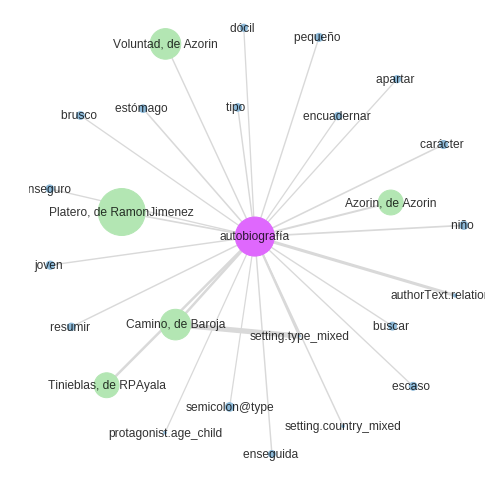

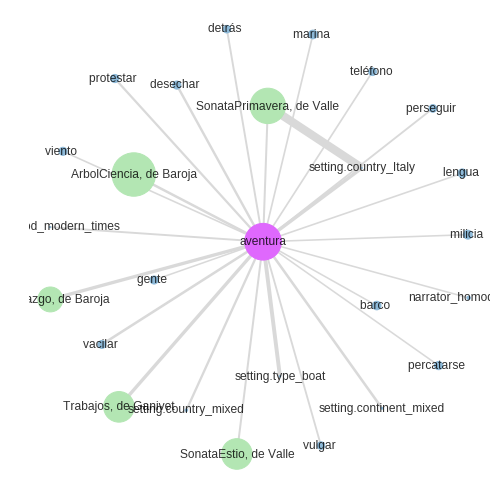

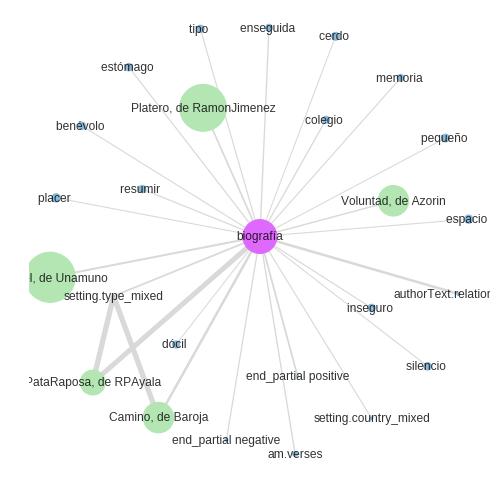

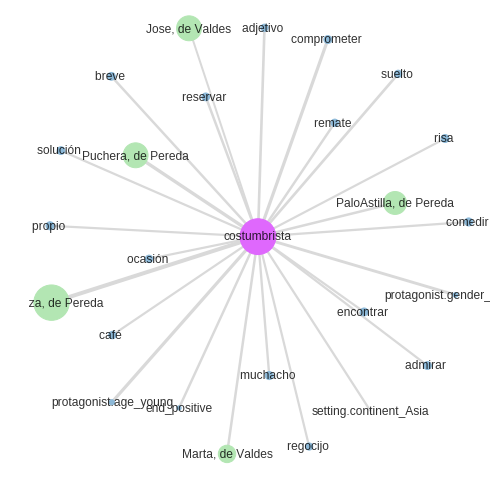

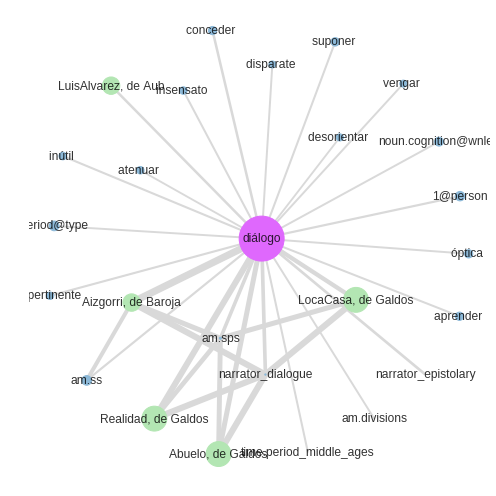

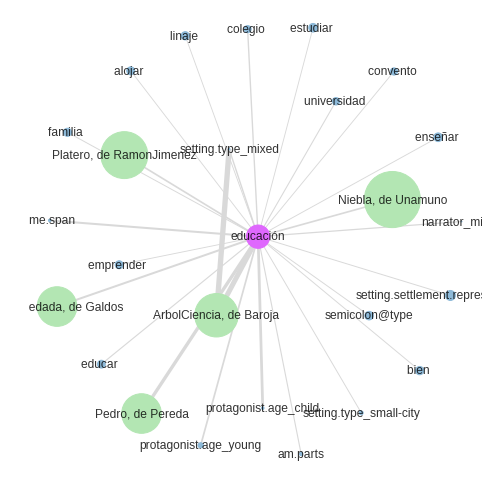

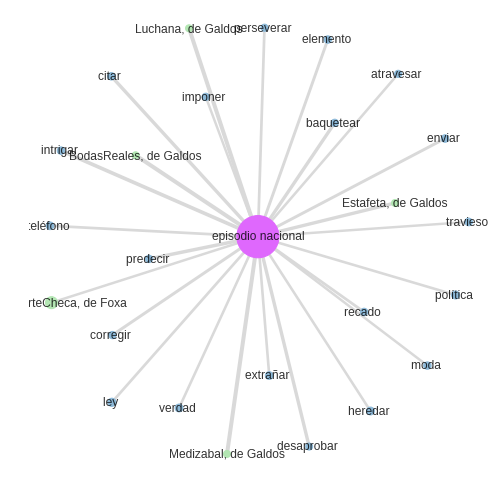

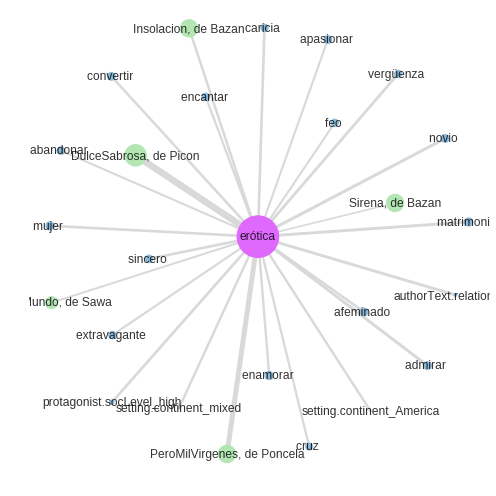

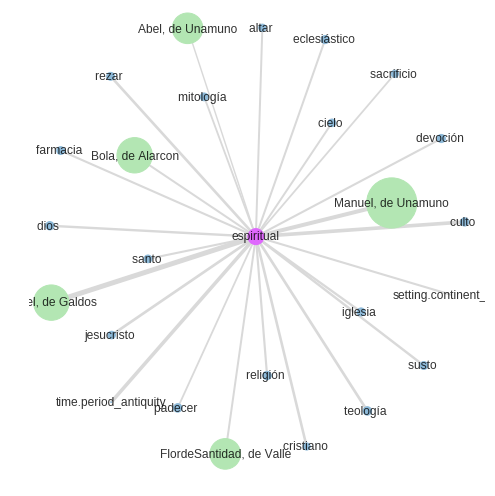

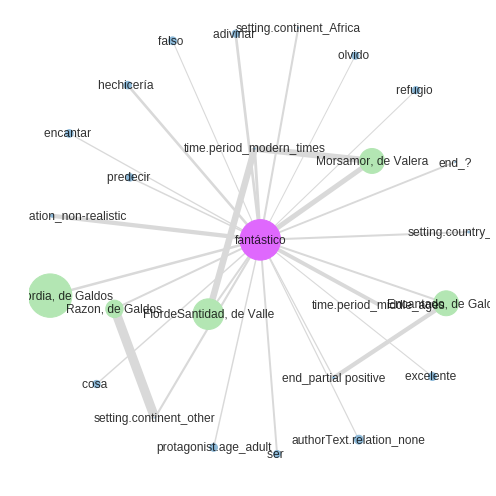

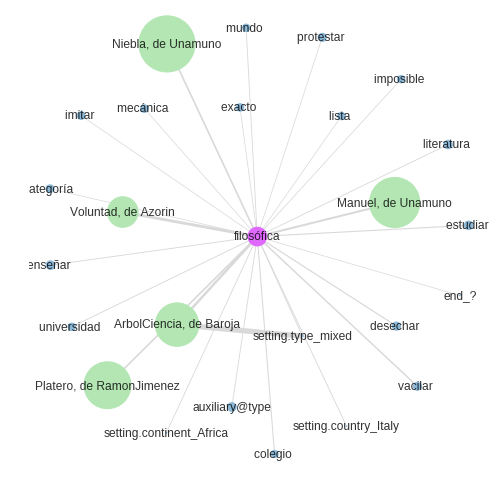

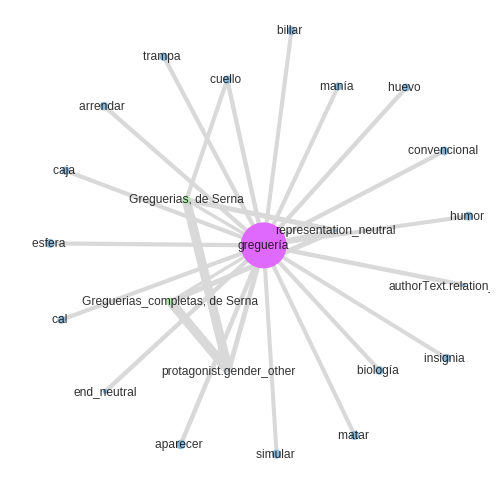

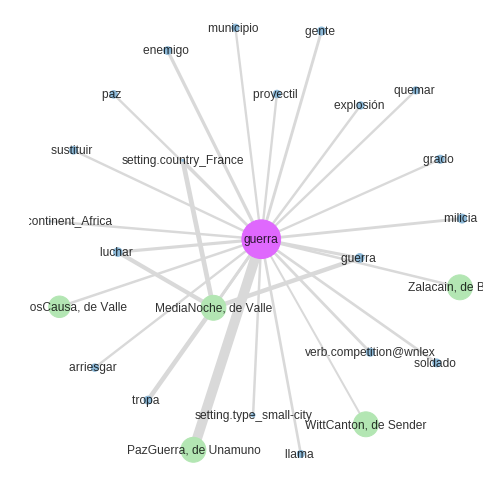

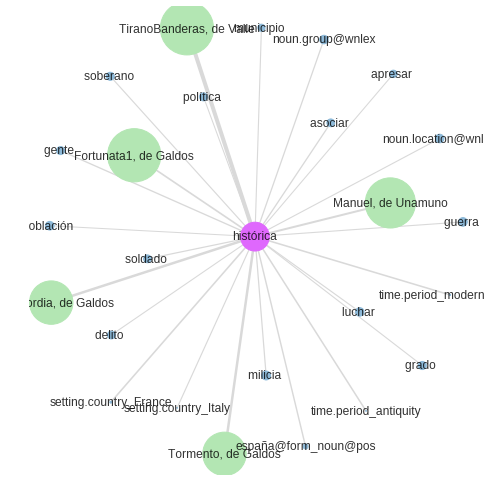

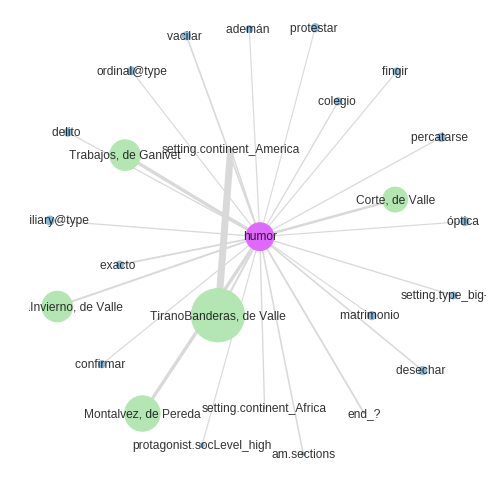

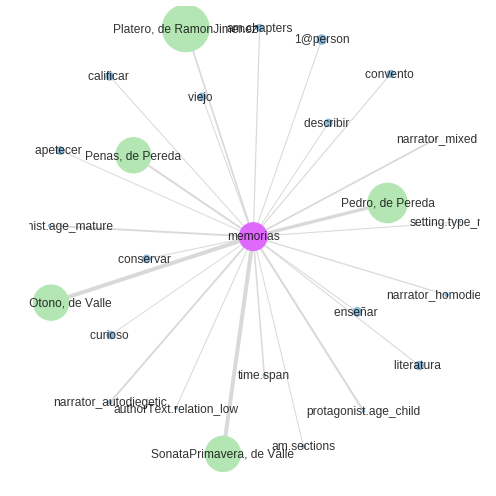

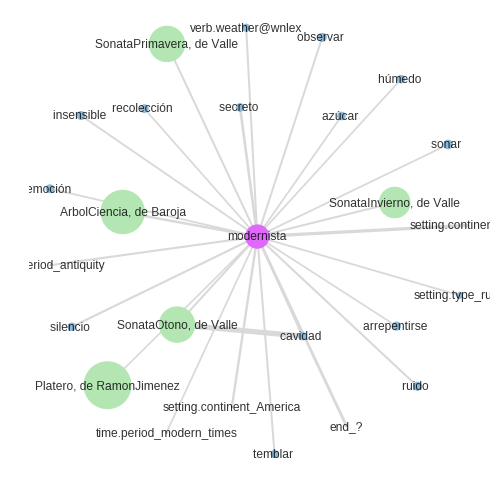

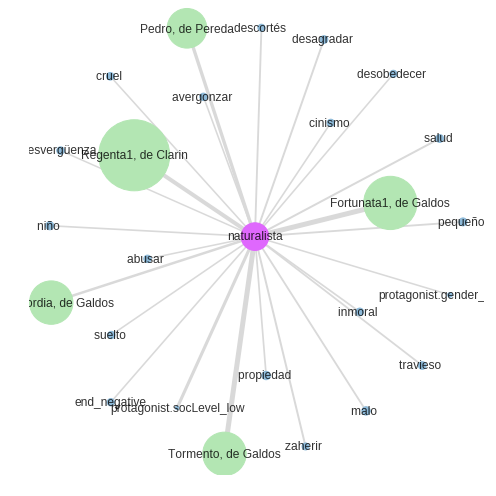

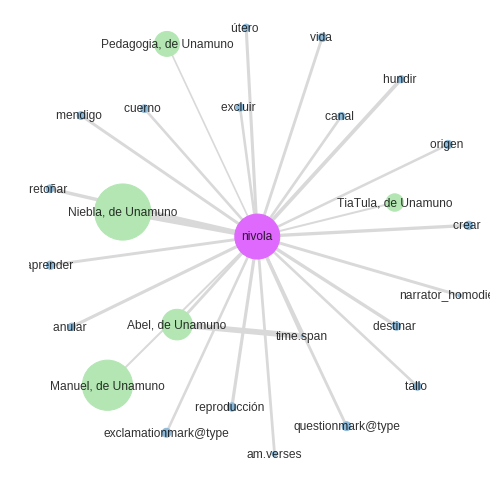

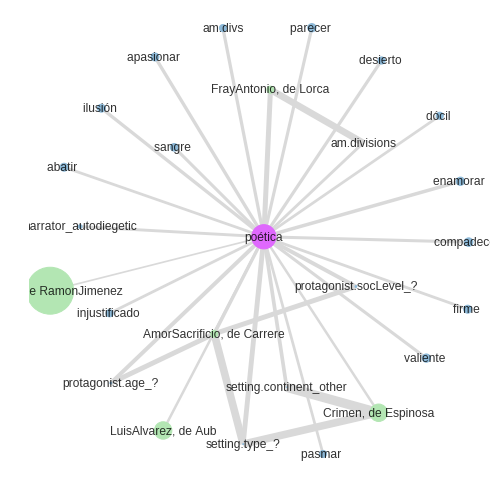

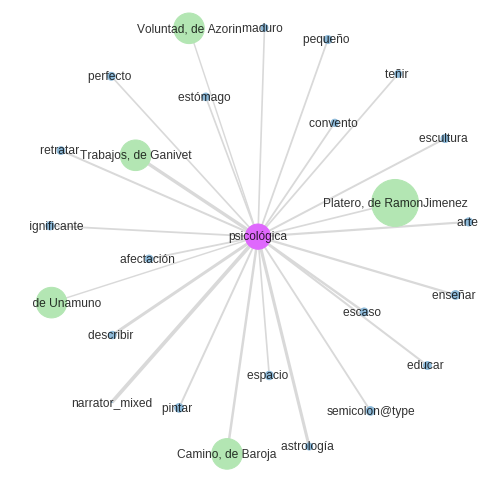

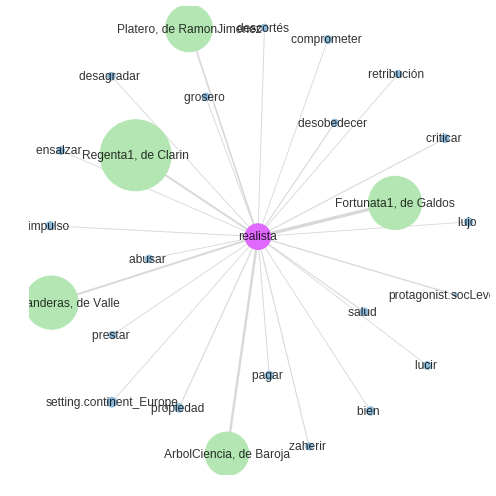

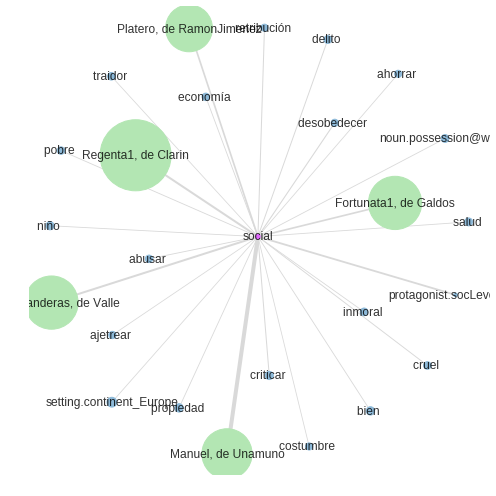

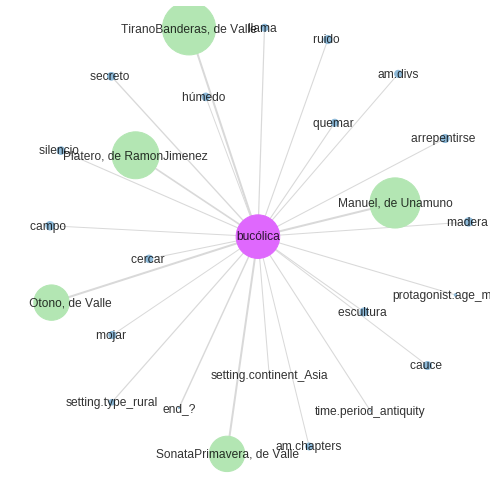

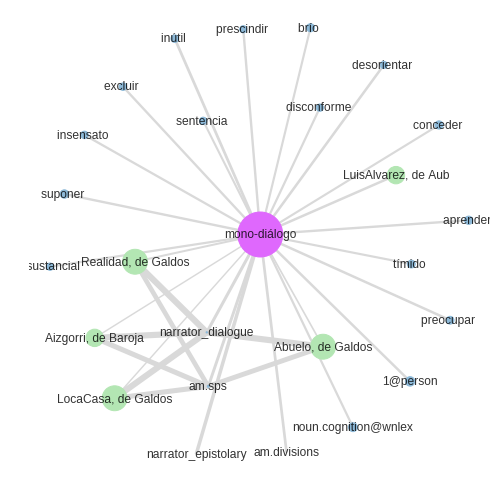

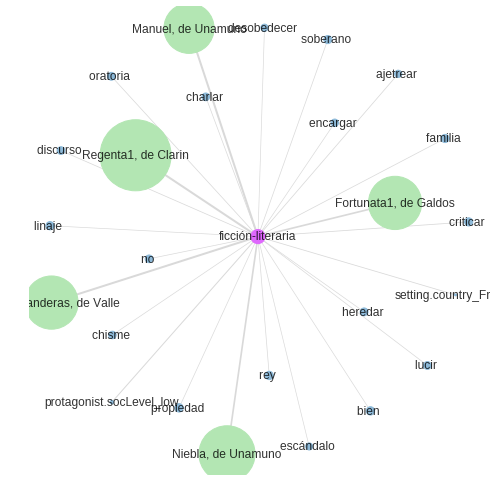

In [83]:
for semantic_subgenre_st in semantic_subgenres_lt:
    graph_subgenre_gp = graph_gp.copy()
    for node in list(graph_subgenre_gp.nodes()):
        #print(node)
        if (node not in list(graph_subgenre_gp.neighbors(semantic_subgenre_st))) and (node != semantic_subgenre_st):
            #print("deleting")
            graph_subgenre_gp.remove_node(node)


    color_dict = {0:'#df68fd',1:'#8db9d8', 2:"#b3e6b3"}
    color_list = [color_dict[i[1]] for i in graph_subgenre_gp.nodes.data('bipartite')]
    sizes = [[graph_subgenre_gp.node[n]['size']*100] for n in graph_subgenre_gp.nodes()]
    widths = [w['weight'] for (u, v, w) in graph_subgenre_gp.edges(data=True)]
    labels_list = {}
    for key, values in dict(graph_subgenre_gp.nodes(data=True)).items():
        labels_list[key] = values["label"]
    

    pos = nx.nx_agraph.graphviz_layout(graph_subgenre_gp, prog="neato")
    plt.figure(figsize=(7,7))
    plt.axis('off')
    nx.draw_networkx_labels(graph_subgenre_gp, pos, labels_list, font_color = 'black', alpha = 0.8)
    nx.draw_networkx_edges(graph_subgenre_gp, pos, edge_color = "#d9d9d9",width = widths)
    nx.draw_networkx_nodes(graph_subgenre_gp, pos, node_size=sizes, node_color=color_list)

    plt.tight_layout()
    plt.savefig(wdir+"/visualisations/graph_"+semantic_subgenre_st+".png",dpi=300, format="png")
    
    plt.show()